# Modelling with Logistic Regression and Linear SVM with SGD training using TF-IDF Vectorizer

Previously compared countvect and TFIDF vectorizers across a number of baseline models.

Best default models was the random forest when comparing the accuracy scores but also took the longest time so picked logistic regression and linear SVM with SGD training models as almost just as good score but faster.

In [1]:
import joblib
import pandas as pd
import numpy as np

#Model imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import metrics
import scikitplot as skplt

#setting plot styles
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['cornflowerblue', '#4cb083'])
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
orig_df = joblib.load('data/reviewdf_data_eda')

In [3]:
print(orig_df.shape)
df = orig_df[orig_df.helpful != 'unclassified']
print(df.shape)

(75960, 15)
(64578, 15)


In [4]:
df.helpful.value_counts(normalize=True)

helpful        0.546781
not-helpful    0.453219
Name: helpful, dtype: float64

Baseline accuracy of 55%, slight class imbalance

In [5]:
X = df.review
y = df.helpful

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=1)

## TFIDF Pipeline w/ LogReg

In [6]:
pipe = make_pipeline(TfidfVectorizer(),
                      LogisticRegression())

In [7]:
pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'logisticregression': LogisticRegression(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tf

### Baseline TFIDF

I'll be using the F1 score to assess perrformance of each model - taking the harmonic mean of the precision and recall.

In [8]:
pipe = make_pipeline(TfidfVectorizer(),
                      LogisticRegression(multi_class='ovr',solver = 'saga', max_iter = 1000, 
                                         n_jobs = -2, random_state=1))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(cross_val_score(pipe, X_train, y_train, cv=5).mean())
print(pipe.score(X_test, y_test))

0.7436994309163408
0.6613178204129997
0.6588727160111489


In [9]:
predictions_test =  pipe.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions_test, normalize='true'))
print('F1 Score: ', metrics.f1_score(y_test, predictions_test, average = "macro"))

[[0.71707732 0.28292268]
 [0.41134267 0.58865733]]
F1 Score:  0.6534341204390616


Even though the class imbalance is relatively small, the model is still more biased towards predicting the majority class. Both true positives and false positives.

I'll try using the class_weights = ‘balanced’ parameter to see if this will improve the model. This automatically assigns the class weights inversely proportional to their respective frequencies penalizing the misclassification made by the minority class by giving it a higher class weight.

In [10]:
pipe = make_pipeline(TfidfVectorizer(),
                      LogisticRegression(multi_class='ovr',solver = 'saga', max_iter = 1000, 
                                         class_weight = 'balanced', n_jobs = -2, random_state=1))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(cross_val_score(pipe, X_train, y_train, cv=5).mean())
print(pipe.score(X_test, y_test))

0.7347954008749177
0.6564206297314525
0.6556983586249613


In [11]:
predictions_test =  pipe.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions_test, normalize='true'))
print('F1 Score: ', metrics.f1_score(y_test, predictions_test, average = "macro"))

[[0.6492495  0.3507505 ]
 [0.33652204 0.66347796]]
F1 Score:  0.6546811729853828


The class predictions for not helpful have improved by doing this, F1 score shows small improvement aswell.

### Testing stopwords and uppercasing with gridsearch

In [12]:
pipe = make_pipeline(TfidfVectorizer(),
                      LogisticRegression(multi_class='ovr',solver = 'saga', max_iter = 1000, 
                                         class_weight = 'balanced', random_state=1),
                      )
params = {'tfidfvectorizer__stop_words':[None, 'english'],
          'tfidfvectorizer__lowercase' :[True, False]}

# create a gridsearch object using pipeline and the dictionary above
gs = GridSearchCV(pipe, params, scoring = 'f1_macro', cv=5, n_jobs=-2, verbose=3)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='ovr',
                                                           random_state=1,
                                                           solver='saga'))]),
             n_jobs=-2,
             param_grid={'tfidfvectorizer__lowercase': [True, False],
                         'tfidfvectorizer__stop_words': [None, 'english']},
             scoring='f1_macro', verbose=3)

In [13]:
print(gs.best_score_) #Mean cross-validated score of the best_estimator
print(gs.best_params_)
print(gs.best_estimator_)

0.655004338134689
{'tfidfvectorizer__lowercase': True, 'tfidfvectorizer__stop_words': None}
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='ovr', random_state=1,
                                    solver='saga'))])


In [14]:
results = gs.cv_results_
plotdf = pd.DataFrame.from_dict(results)

In [15]:
plotdf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__lowercase,param_tfidfvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.549448,0.103689,1.020703,0.087684,True,None,"{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.649088,0.658482,0.656658,0.659554,0.651239,0.655004,0.004116,1
1,4.631296,0.158091,0.976689,0.144511,True,english,"{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.647255,0.656057,0.650959,0.650414,0.646905,0.650318,0.003298,3
2,5.300027,0.447149,0.859666,0.118029,False,None,"{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.648221,0.657494,0.659367,0.657892,0.650626,0.654720,0.004435,2
3,3.568120,0.316691,0.544071,0.110694,False,english,"{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.644798,0.651004,0.649868,0.648400,0.649846,0.648783,0.002157,4


In [16]:
plotdf.sort_values(by='mean_test_score', inplace=True)

In [17]:
plotdf.mean_test_score = plotdf.mean_test_score*100

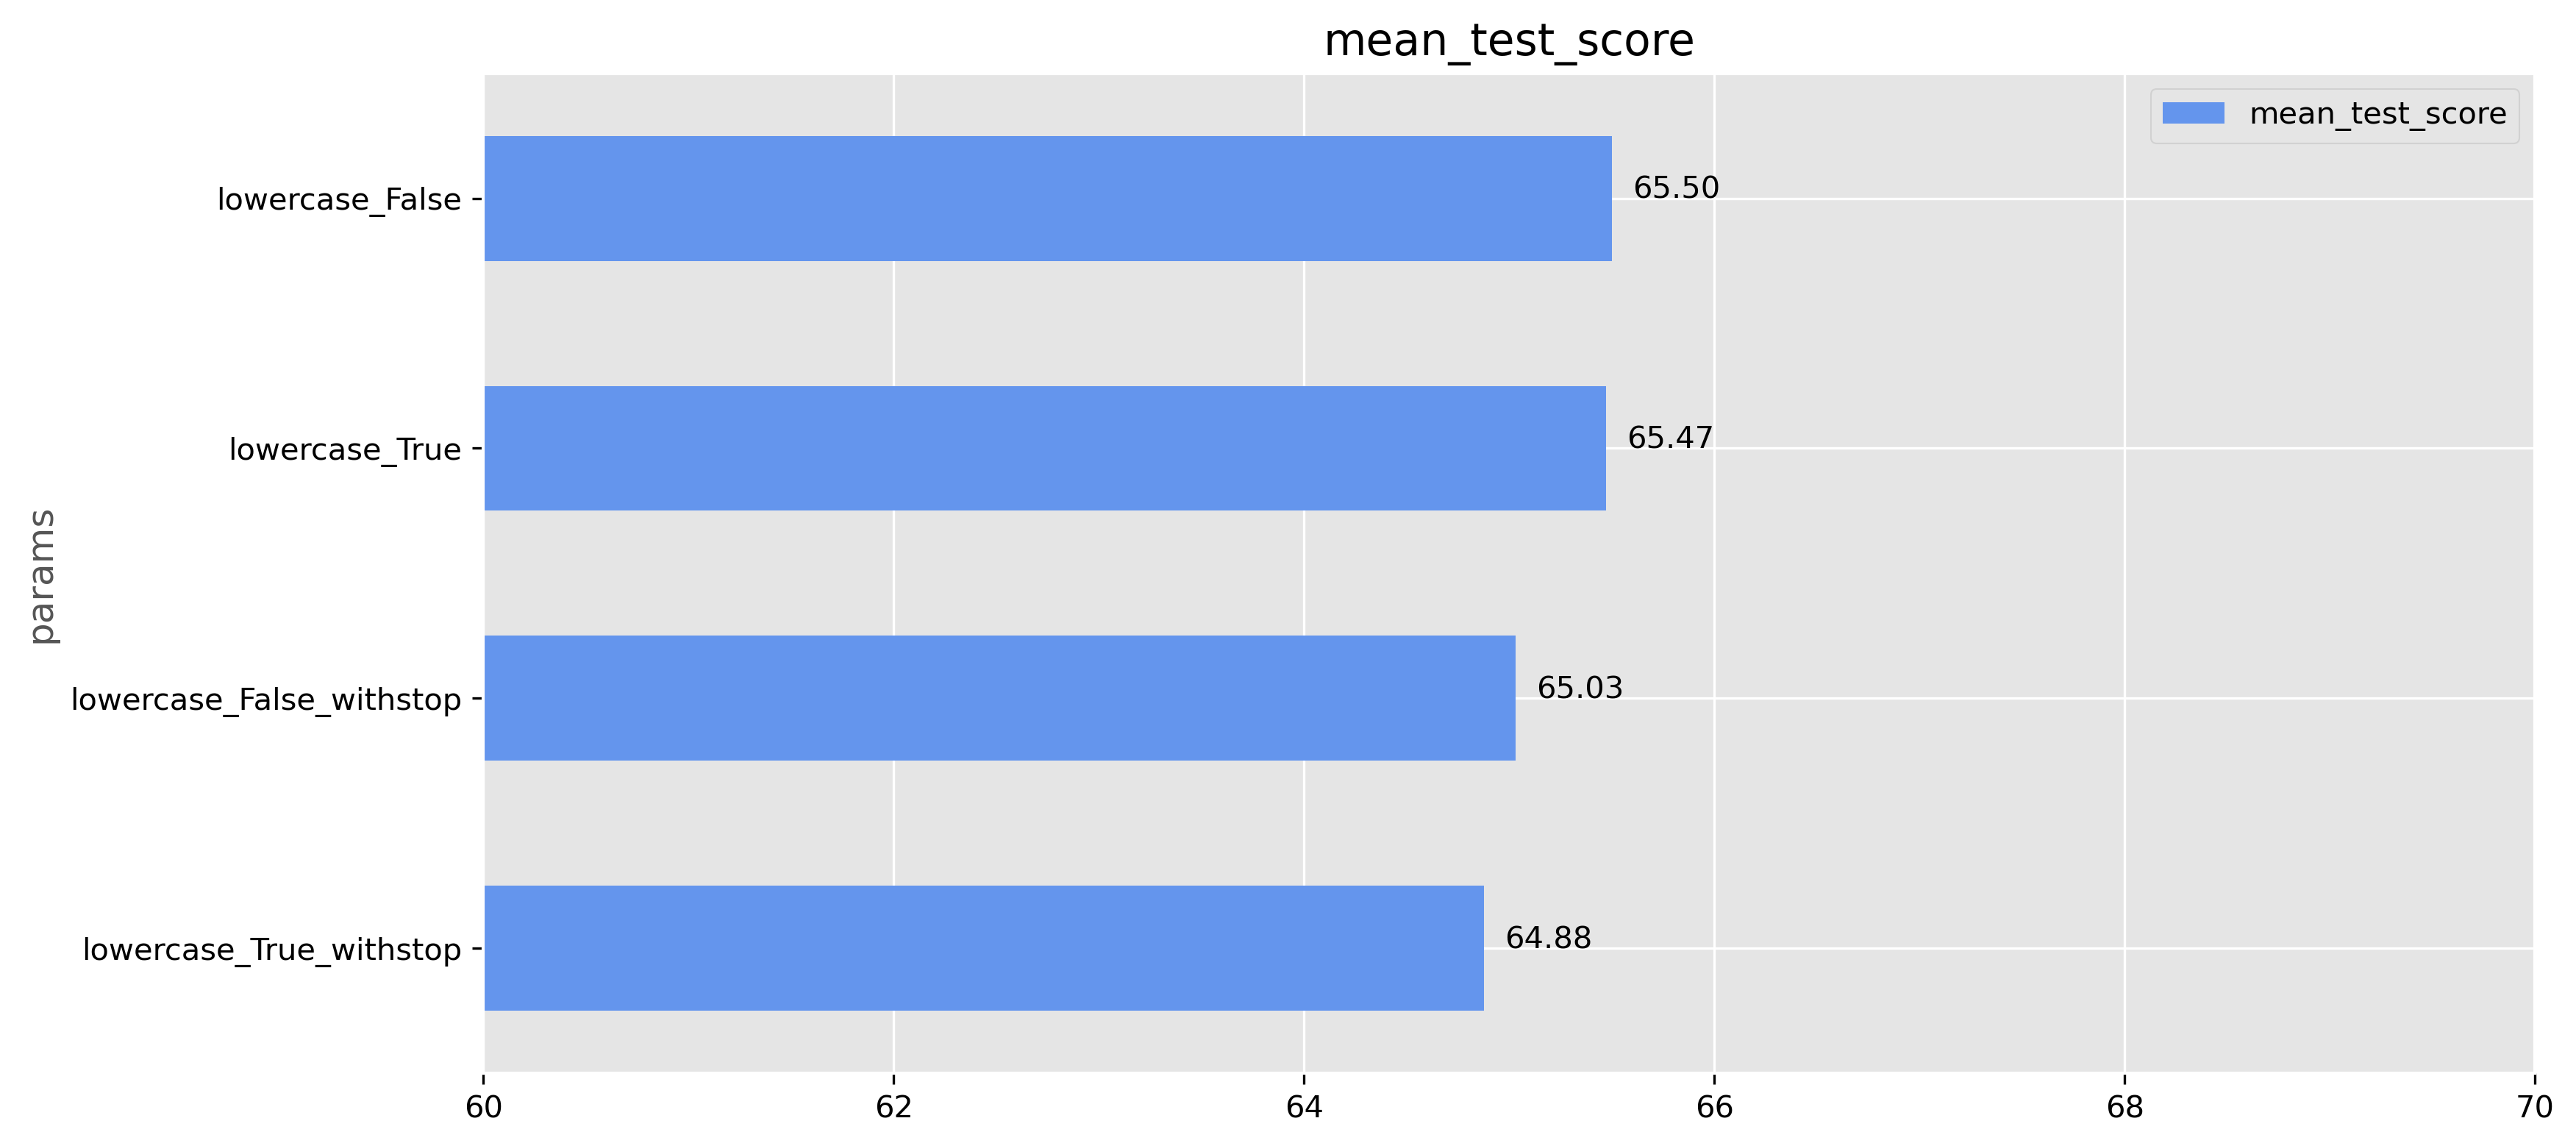

In [18]:
plotdf.plot(y='mean_test_score', x='params', subplots=True,  kind='barh', figsize=(12,6))
plt.xlim([60, 70])
for i, value in enumerate(plotdf.mean_test_score):
    plt.text(value +0.1, i  , str(("%.2f" %value)), fontsize=10)

plt.yticks(range(4), ['lowercase_True_withstop', 'lowercase_False_withstop', 'lowercase_True', 'lowercase_False'], fontsize=10, color='black')
plt.tick_params(colors='black')
plt.show()

Scores are pretty similar - best model here is lowercase False (retain case sensitivity) and without stopwords. Potentially because NLTK stop words includes things like 'not' where negation might be important in reviews.

### Evaluate best result

In [19]:
predictions_train, predictions_test =  gs.predict(X_train), gs.predict(X_test)

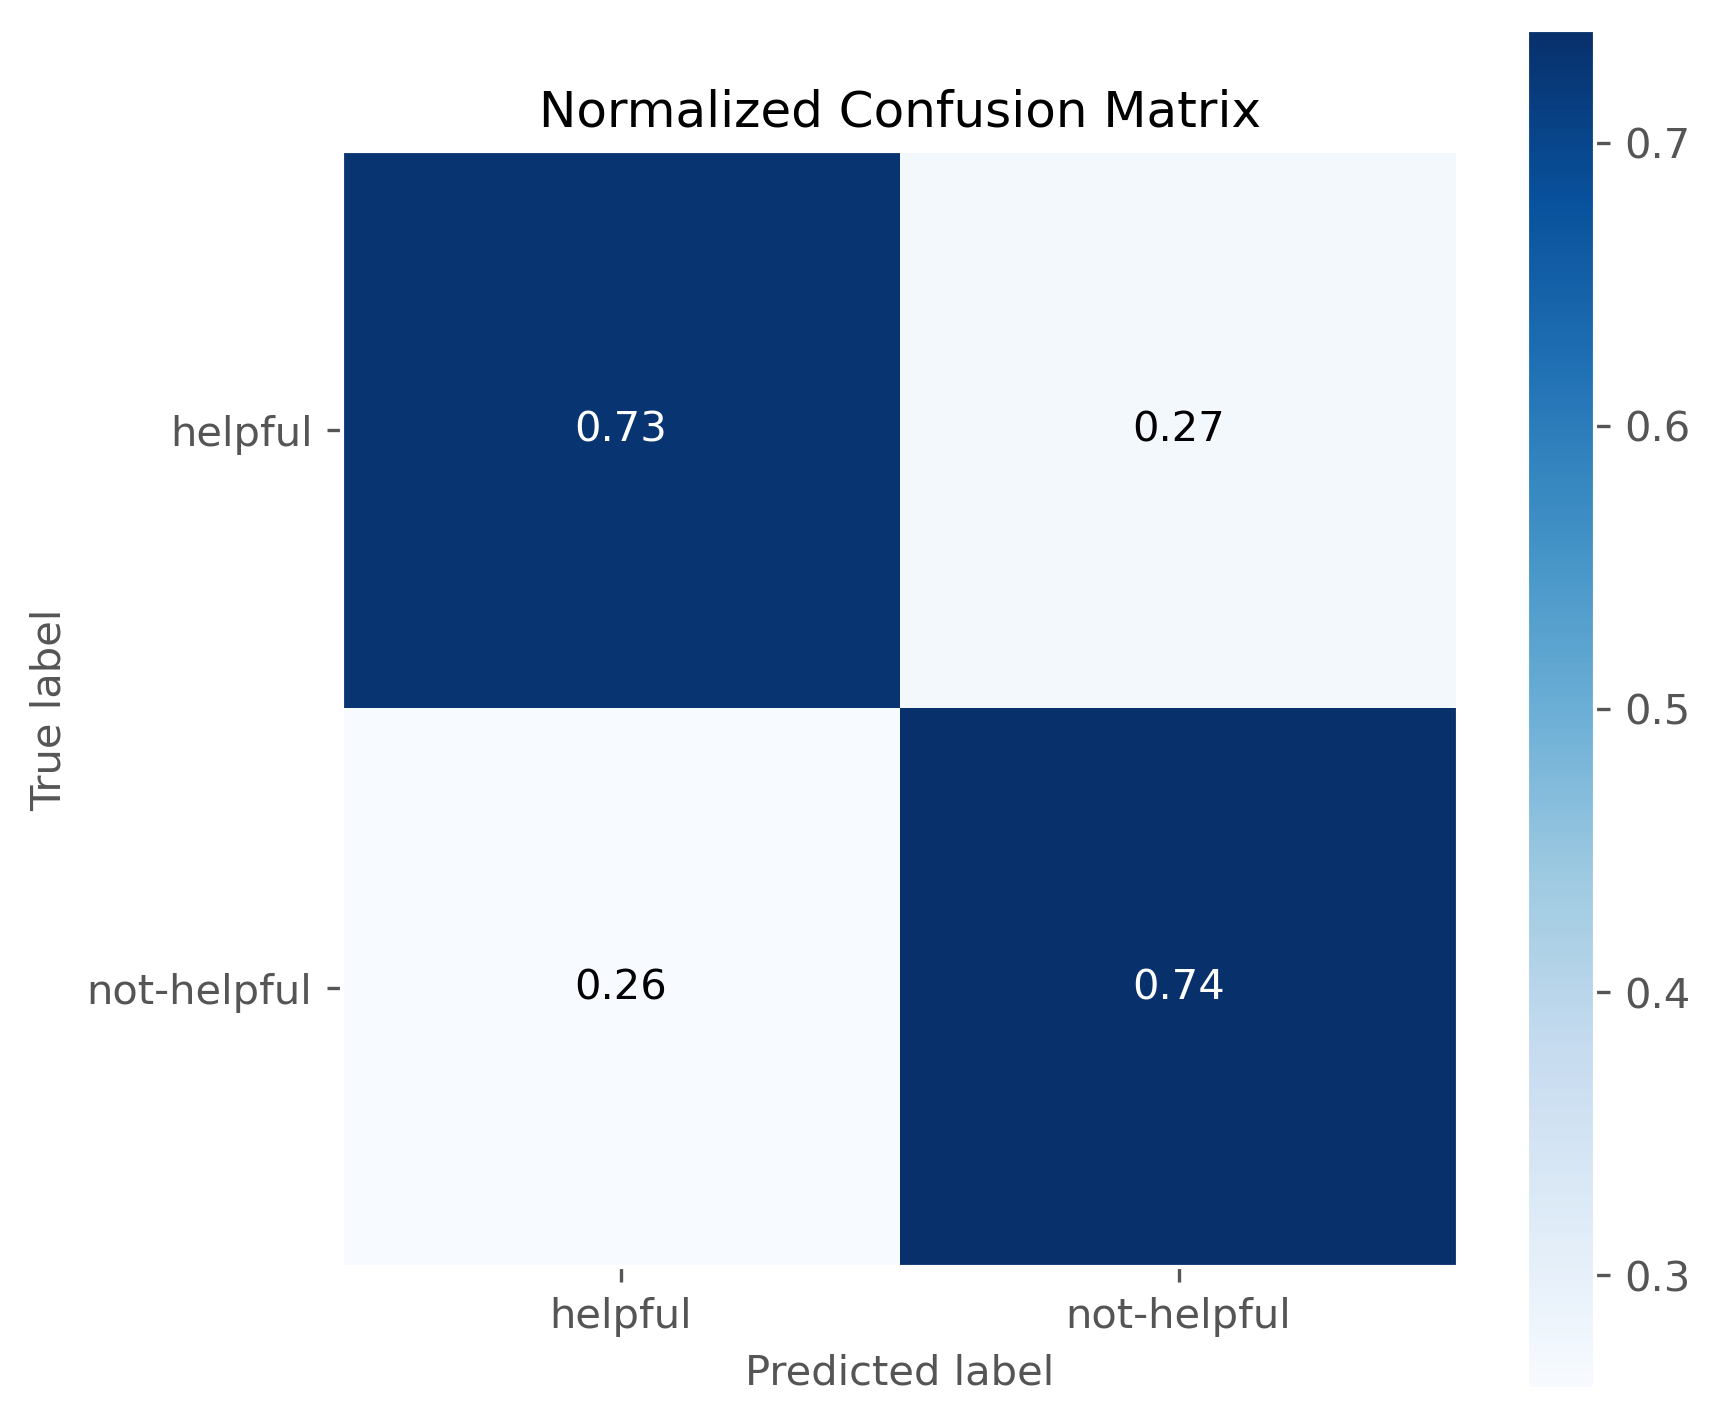

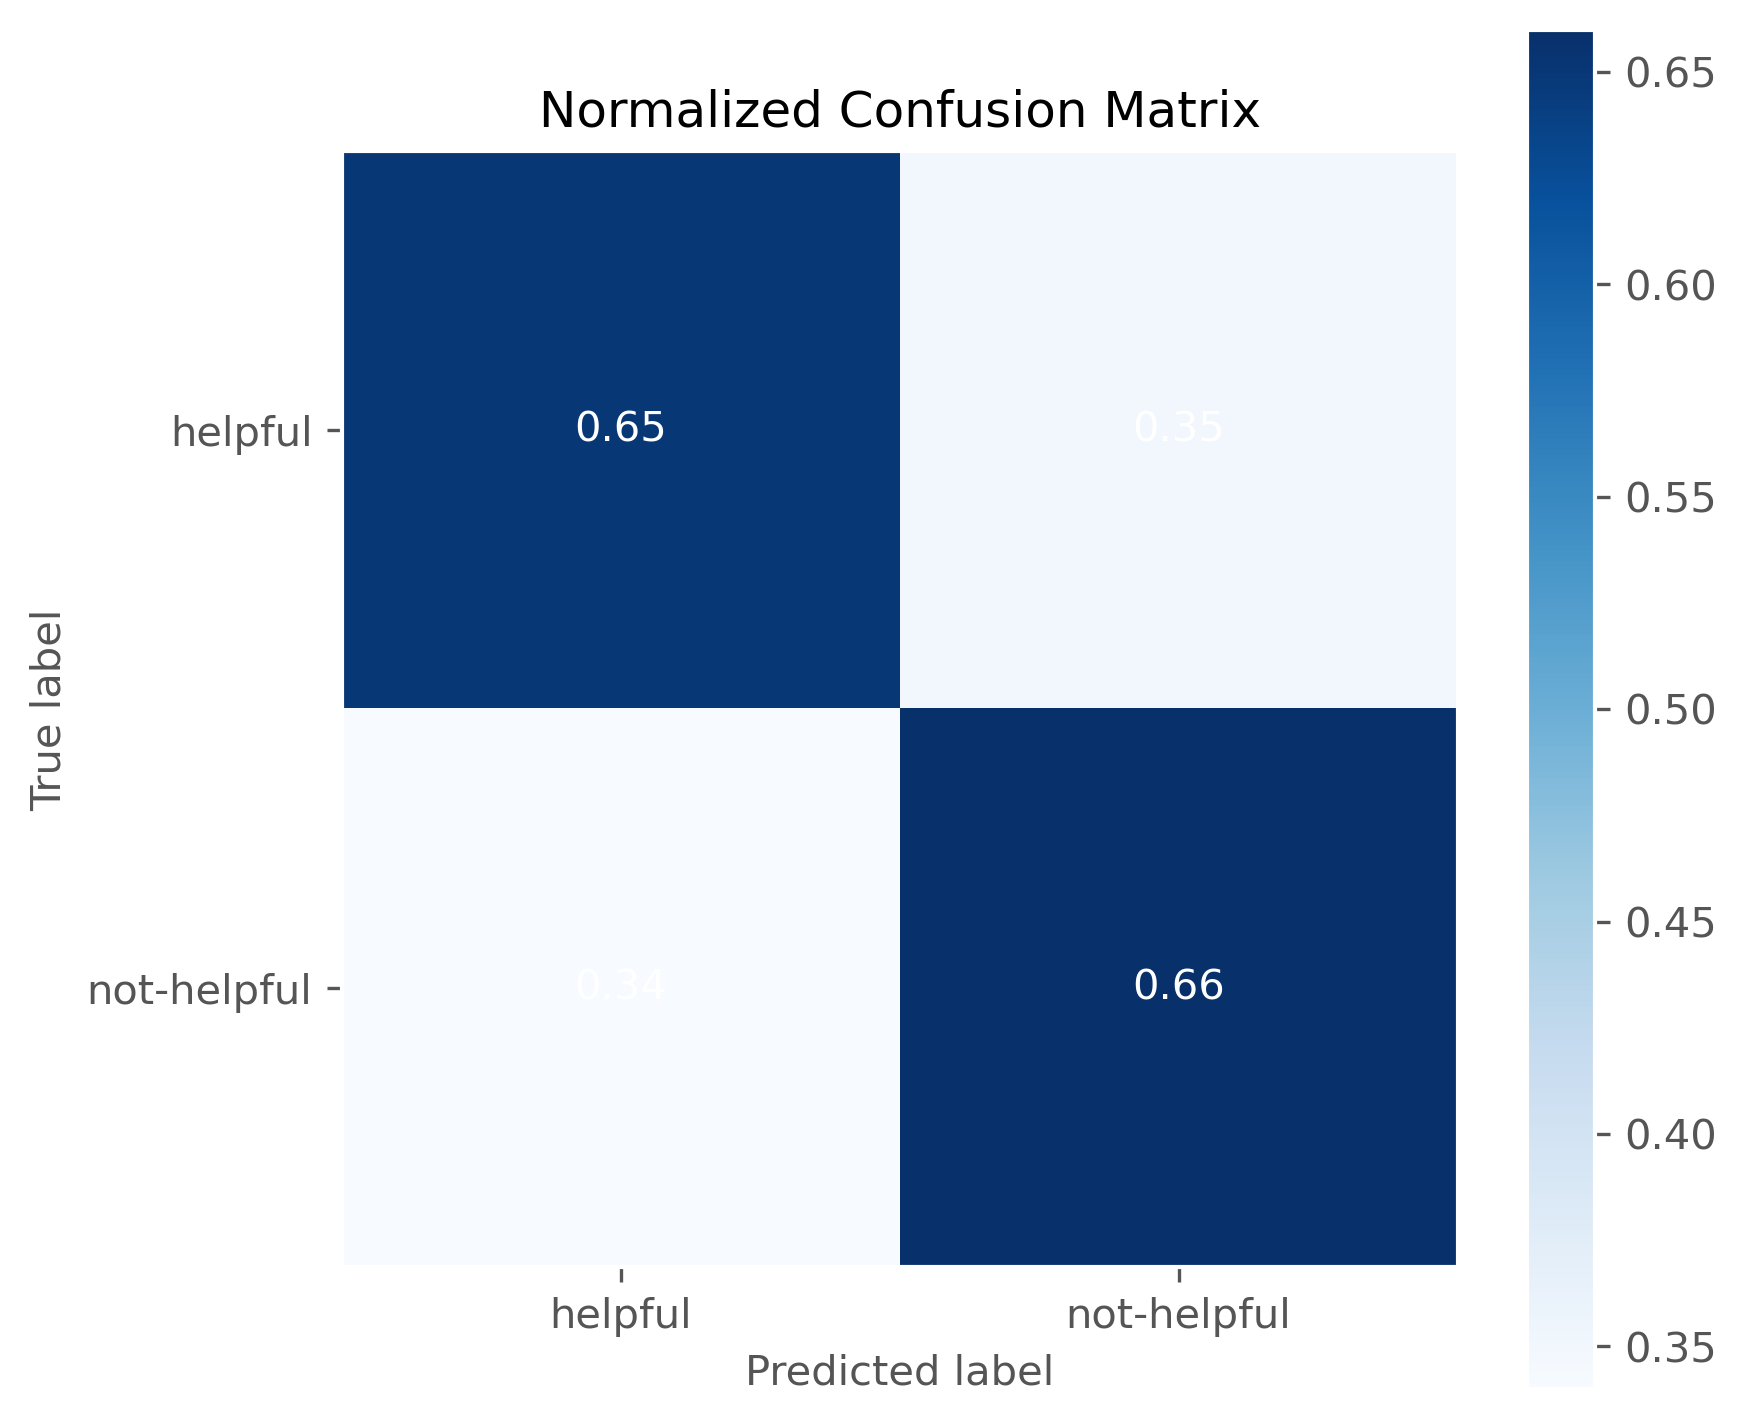

In [20]:
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, normalize = 'all',  figsize=(6,6))
plt.show()
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, normalize='all',figsize=(6,6))
plt.show()

### Looking at incorrectly classified texts

In [21]:
predicted = gs.predict(df.review)
# Incorrectly classified
incorrect_preds = df[(predicted != df.helpful)]
incorrect_preds = (predicted != df.helpful)

In [22]:
incorrect_preds.shape

(64578,)

In [23]:
incorrect_df = pd.DataFrame({'actual': df.helpful,
                             'predicted': predicted,
                             'mismatch': incorrect_preds,
                             'TEXT': df.review})

incorrect_df[incorrect_df.mismatch == True].head(10)

,actual,predicted,mismatch,TEXT
8,helpful,not-helpful,True,my ball itch holy shit
13,not-helpful,helpful,True,you get DJ Scully and a bunch of other wanker ...
32,helpful,not-helpful,True,nice character KF without they be not that nice
40,not-helpful,helpful,True,Mr Foster my gay fetish
41,not-helpful,helpful,True,you be oblige to buy this DLC just because of ...
45,not-helpful,helpful,True,currency seven ninety - nine for four characte...
48,not-helpful,helpful,True,got it for one reason and one reason alone Mr ...
54,not-helpful,helpful,True,the race seven expansion that make you wish yo...
59,helpful,not-helpful,True,great map pack overprice as hell in my opinion...
60,helpful,not-helpful,True,steam still sell map pack dlc that no long wor...


Next look at the features the classifier is using to make decisions.

In [24]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [25]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Not Helpful', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Helpful', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [26]:
pipe = make_pipeline(TfidfVectorizer(lowercase=False),
                      LogisticRegression(multi_class='ovr',solver = 'saga', max_iter = 1000, 
                                         class_weight = 'balanced', n_jobs = -2, random_state=1))

pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(lowercase=False)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='ovr', n_jobs=-2,
                                    random_state=1, solver='saga'))])

In [27]:
importance = get_most_important_features(pipe['tfidfvectorizer'], pipe['logisticregression'], 10)

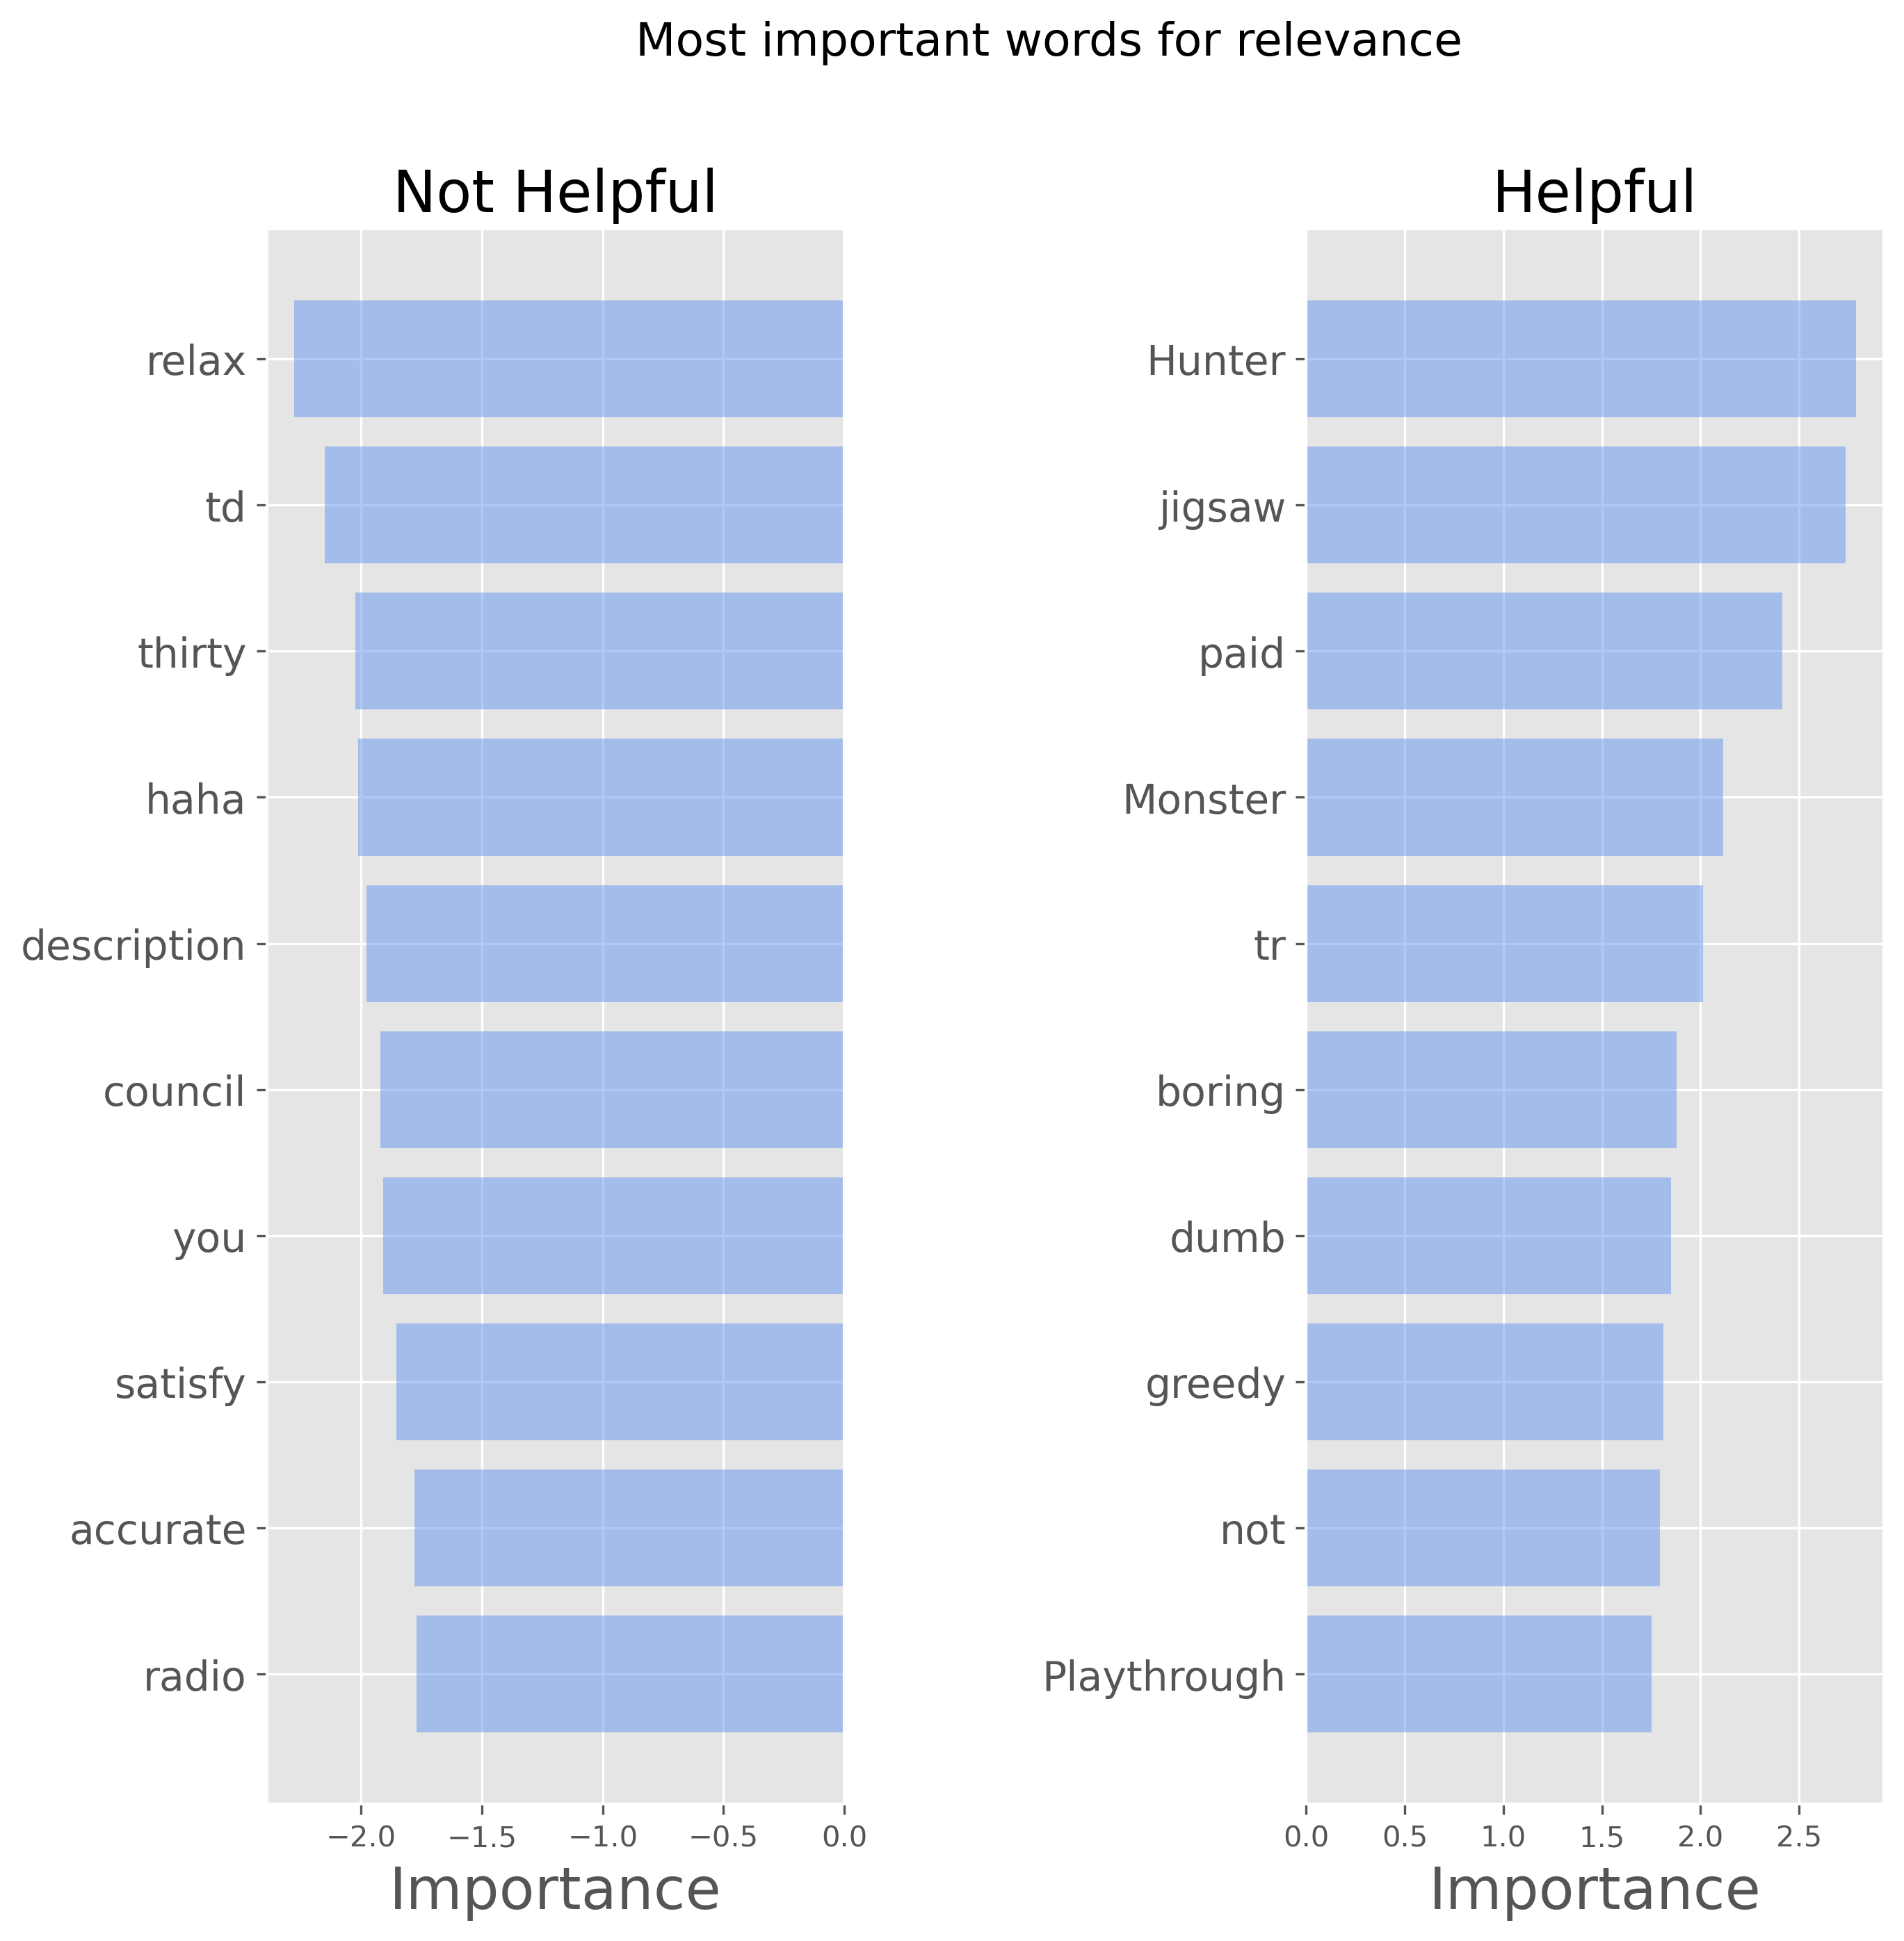

In [28]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Can see that the model returns a high coefficient for 'not' which would've been removed using NLTKs stop words.

Words such as 'paid', 'boring', 'playthrough' can make sense for why a review has been rated more helpful - users have paid for the game and maybe had a decent amount of playtime.

Other than that the top words returned on their own don't seem to give too much information.

I'll try comparing the n_grams next

In [29]:
stop = ['td', 'tr', 'th']

### Precision-recall and ROC curve

In [30]:
probabilities_train = pipe.predict_proba(X_train)
probabilities_test = pipe.predict_proba(X_test)
cmap = ListedColormap(sns.color_palette("husl", len(pipe.classes_)))

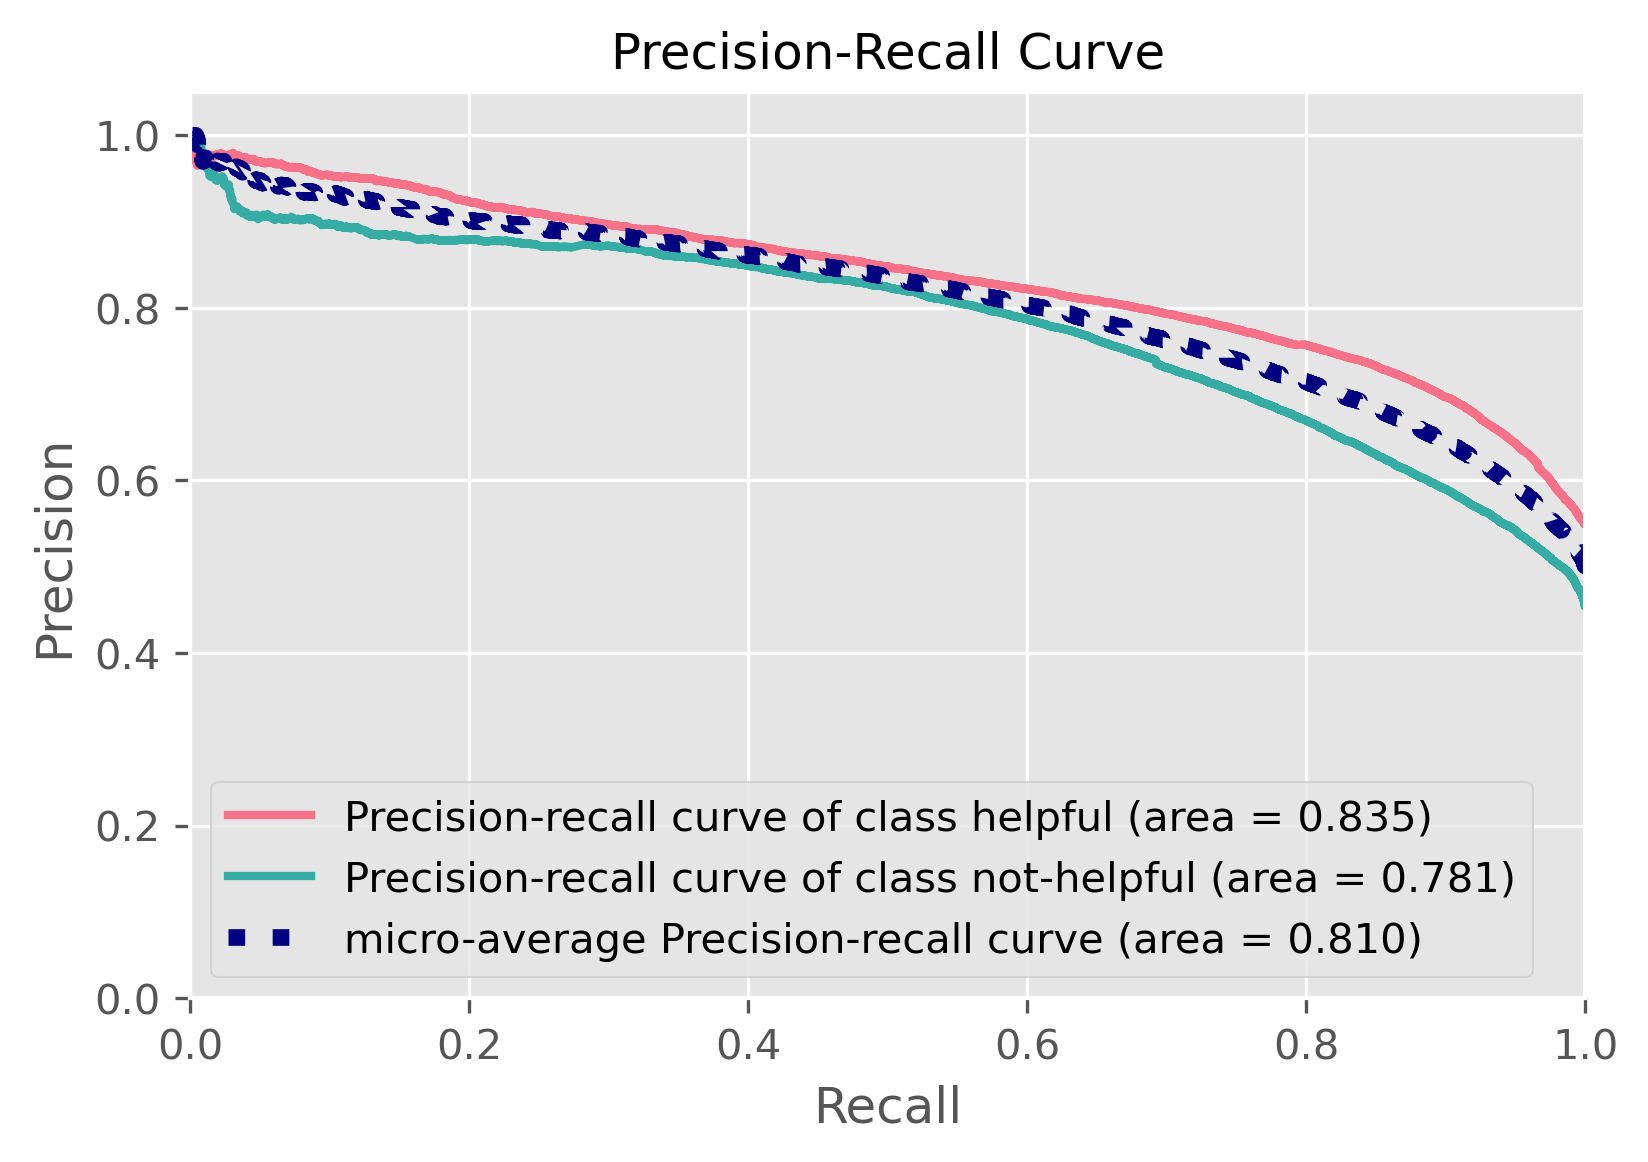

In [31]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train, cmap=cmap)
plt.show()

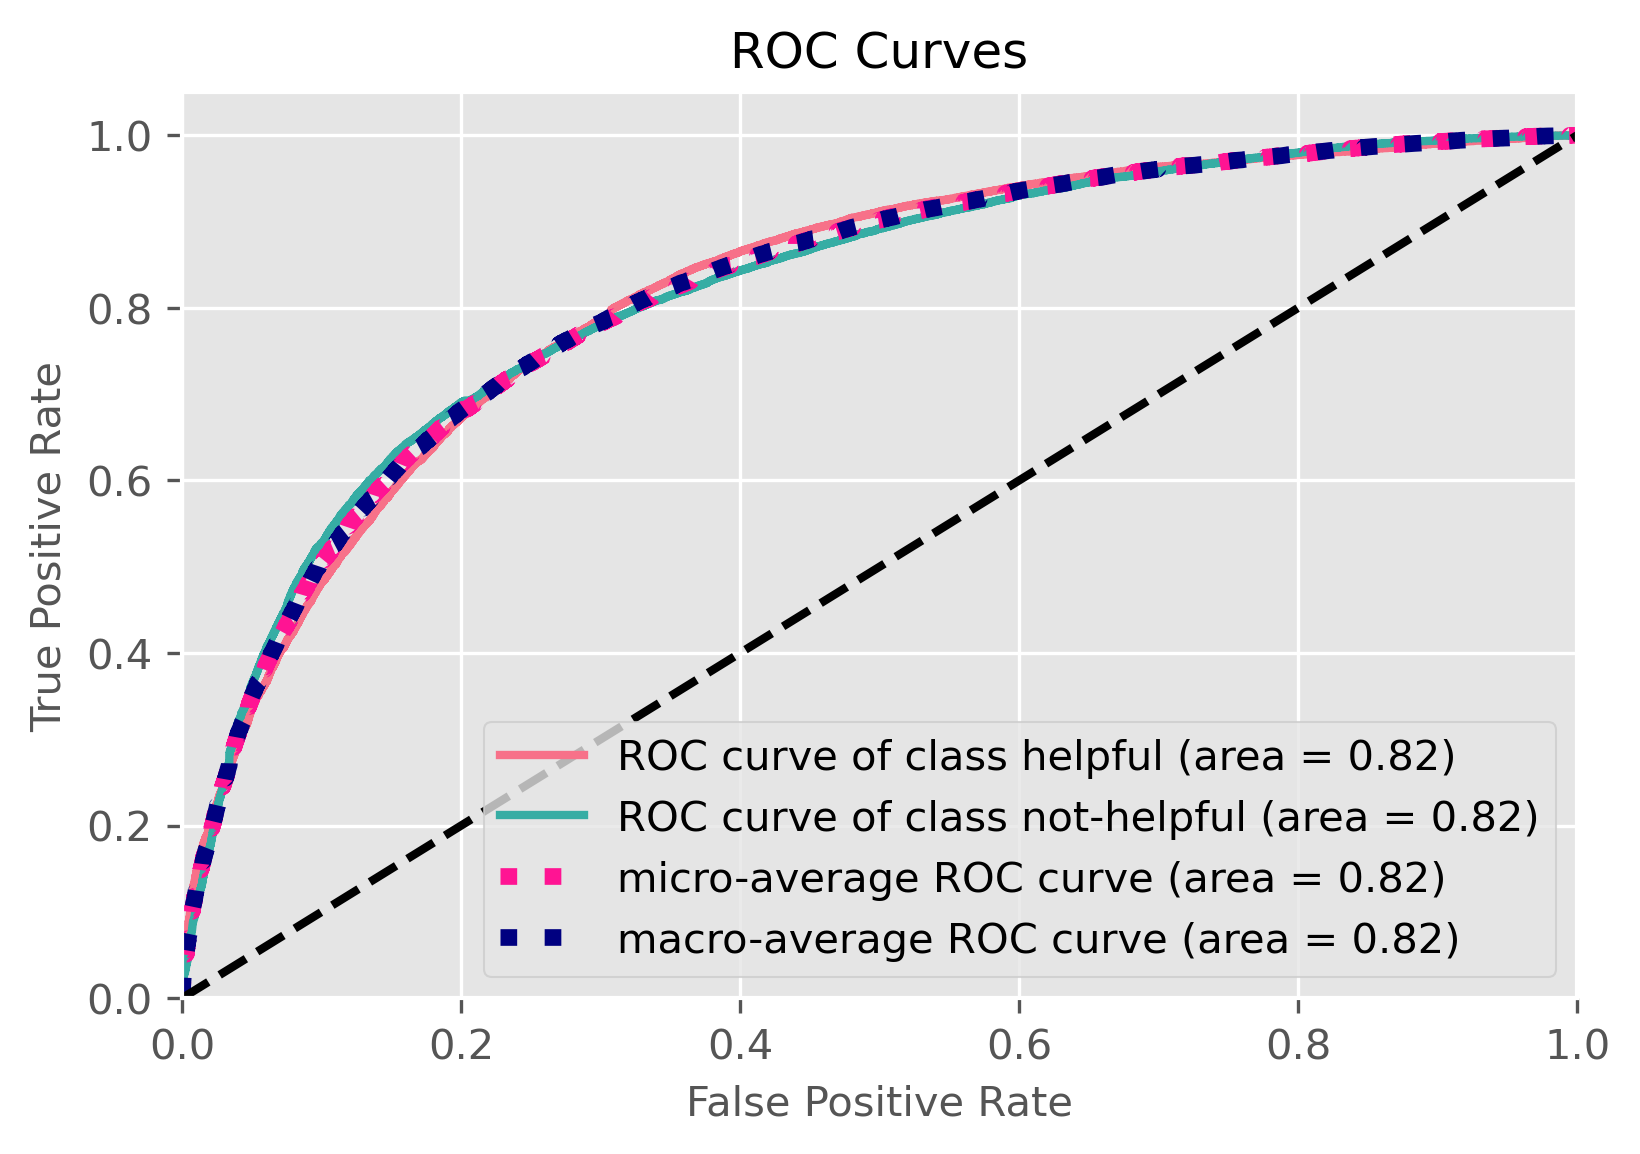

In [32]:
skplt.metrics.plot_roc(y_train, probabilities_train, cmap=cmap)
plt.show()

evaluate this

### Comparison of n_gram ranges

In [33]:
pipe_ngram = make_pipeline(TfidfVectorizer(stop_words=stop),
                      LogisticRegression(multi_class='ovr',solver = 'saga', class_weight = 'balanced' ,
                                         max_iter = 1000, random_state=1),
                      )
params_ngram = {'tfidfvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
                'tfidfvectorizer__lowercase': [True, False]}

# create a gridsearch object using pipeline and the dictionary above
gs_nlr = GridSearchCV(pipe_ngram, params_ngram, scoring = 'f1_macro', cv=5, n_jobs=-2, verbose=3)

gs_nlr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['td', 'tr',
                                                                    'th'])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='ovr',
                                                           random_state=1,
                                                           solver='saga'))]),
             n_jobs=-2,
             param_grid={'tfidfvectorizer__lowercase': [True, False],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             scoring='f1_macro', verbose=3)

In [34]:
results_nlr = gs_nlr.cv_results_
plotdf_nlr = pd.DataFrame.from_dict(results_nlr)

In [35]:
plotdf_nlr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__lowercase,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.313171,0.169553,0.856805,0.058116,True,"(1, 1)","{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.648598,0.659639,0.657715,0.658766,0.651645,0.655273,0.004358,5
1,15.591198,0.907461,2.307084,0.135579,True,"(1, 2)","{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.663321,0.672505,0.671071,0.668912,0.663187,0.667799,0.003884,3
2,35.793545,1.167302,4.102549,0.801443,True,"(1, 3)","{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.660744,0.676345,0.671905,0.665283,0.668833,0.668622,0.005361,2
3,5.990580,0.355273,1.011018,0.044389,False,"(1, 1)","{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.648685,0.658247,0.659950,0.657492,0.651219,0.655118,0.004367,6
4,17.184120,1.623083,1.890819,0.164753,False,"(1, 2)","{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.660675,0.669771,0.668358,0.667230,0.667179,0.666643,0.003130,4
5,28.595136,0.248908,2.892302,0.327231,False,"(1, 3)","{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.659454,0.676370,0.669987,0.668839,0.670707,0.669071,0.005465,1


In [36]:
plotdf_nlr.mean_test_score = plotdf_nlr.mean_test_score*100

In [37]:
plotdf_nlr.rename({'param_tfidfvectorizer__lowercase': 'Lowercase', 'param_tfidfvectorizer__ngram_range' : 'N_gram'}, axis=1, inplace=True)

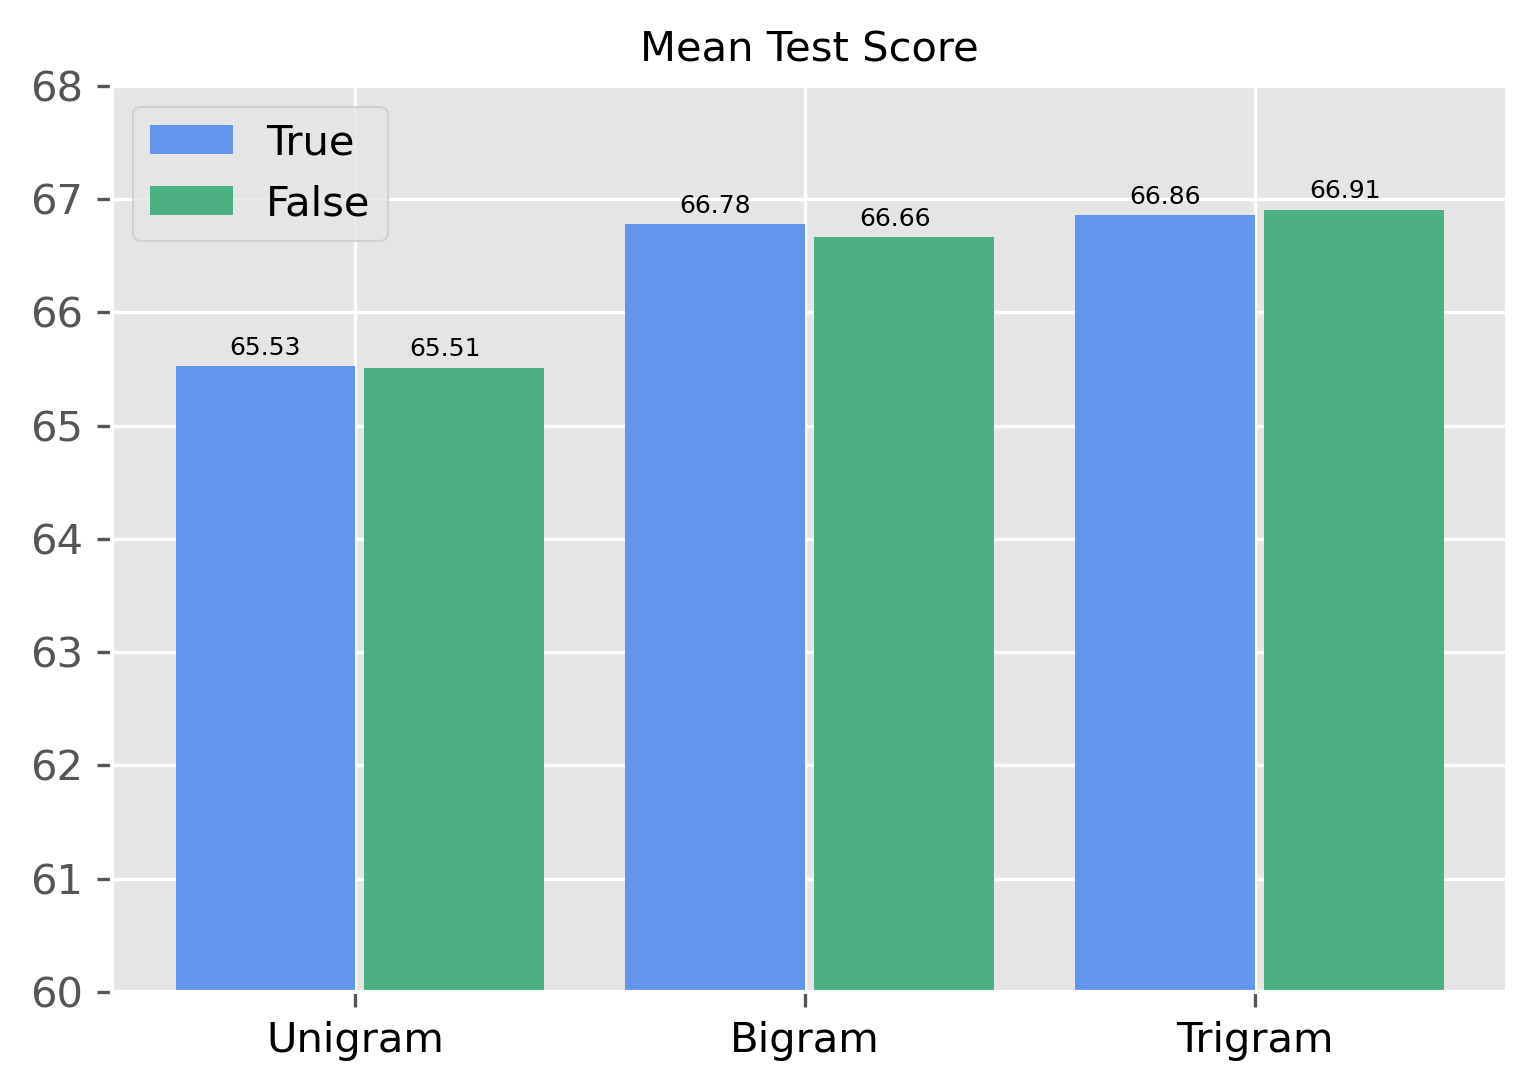

In [39]:
# Set position of bar on X_axis
i = np.arange(3)

# Make plot
plt.bar(i/2, plotdf_nlr[plotdf_nlr.Lowercase == True].mean_test_score, width = 0.2, label='True')
plt.bar(i/2 + 0.21, plotdf_nlr[plotdf_nlr.Lowercase == False].mean_test_score, width = 0.2, label='False')
# Plot text
plt.title('Mean Test Score', fontsize=10)
for i, value in enumerate(plotdf_nlr[plotdf_nlr.Lowercase == True].mean_test_score):
    plt.text(i/2-0.04, value+ 0.1  , str(("%.2f" %value)), fontsize =6)
    
for i, value in enumerate(plotdf_nlr[plotdf_nlr.Lowercase == False].mean_test_score):
    plt.text(i/2+0.16, value+ 0.1  , str(("%.2f" %value)), fontsize =6)
    
plt.xticks([0.1, 0.6, 1.1], ['Unigram', 'Bigram', 'Trigram'], color='black') 
plt.ylim([60, 68])
# Create legend 
plt.legend()
plt.show()

Scores increase if we include higher n_grams however improvement is marginal moving from bigrams to trigrams. Also the casing has minimal difference so would opt to use lowercase=False to reduce dimensionality.

In [40]:
predictions_train_n, predictions_test_n =  gs_nlr.predict(X_train), gs_nlr.predict(X_test)

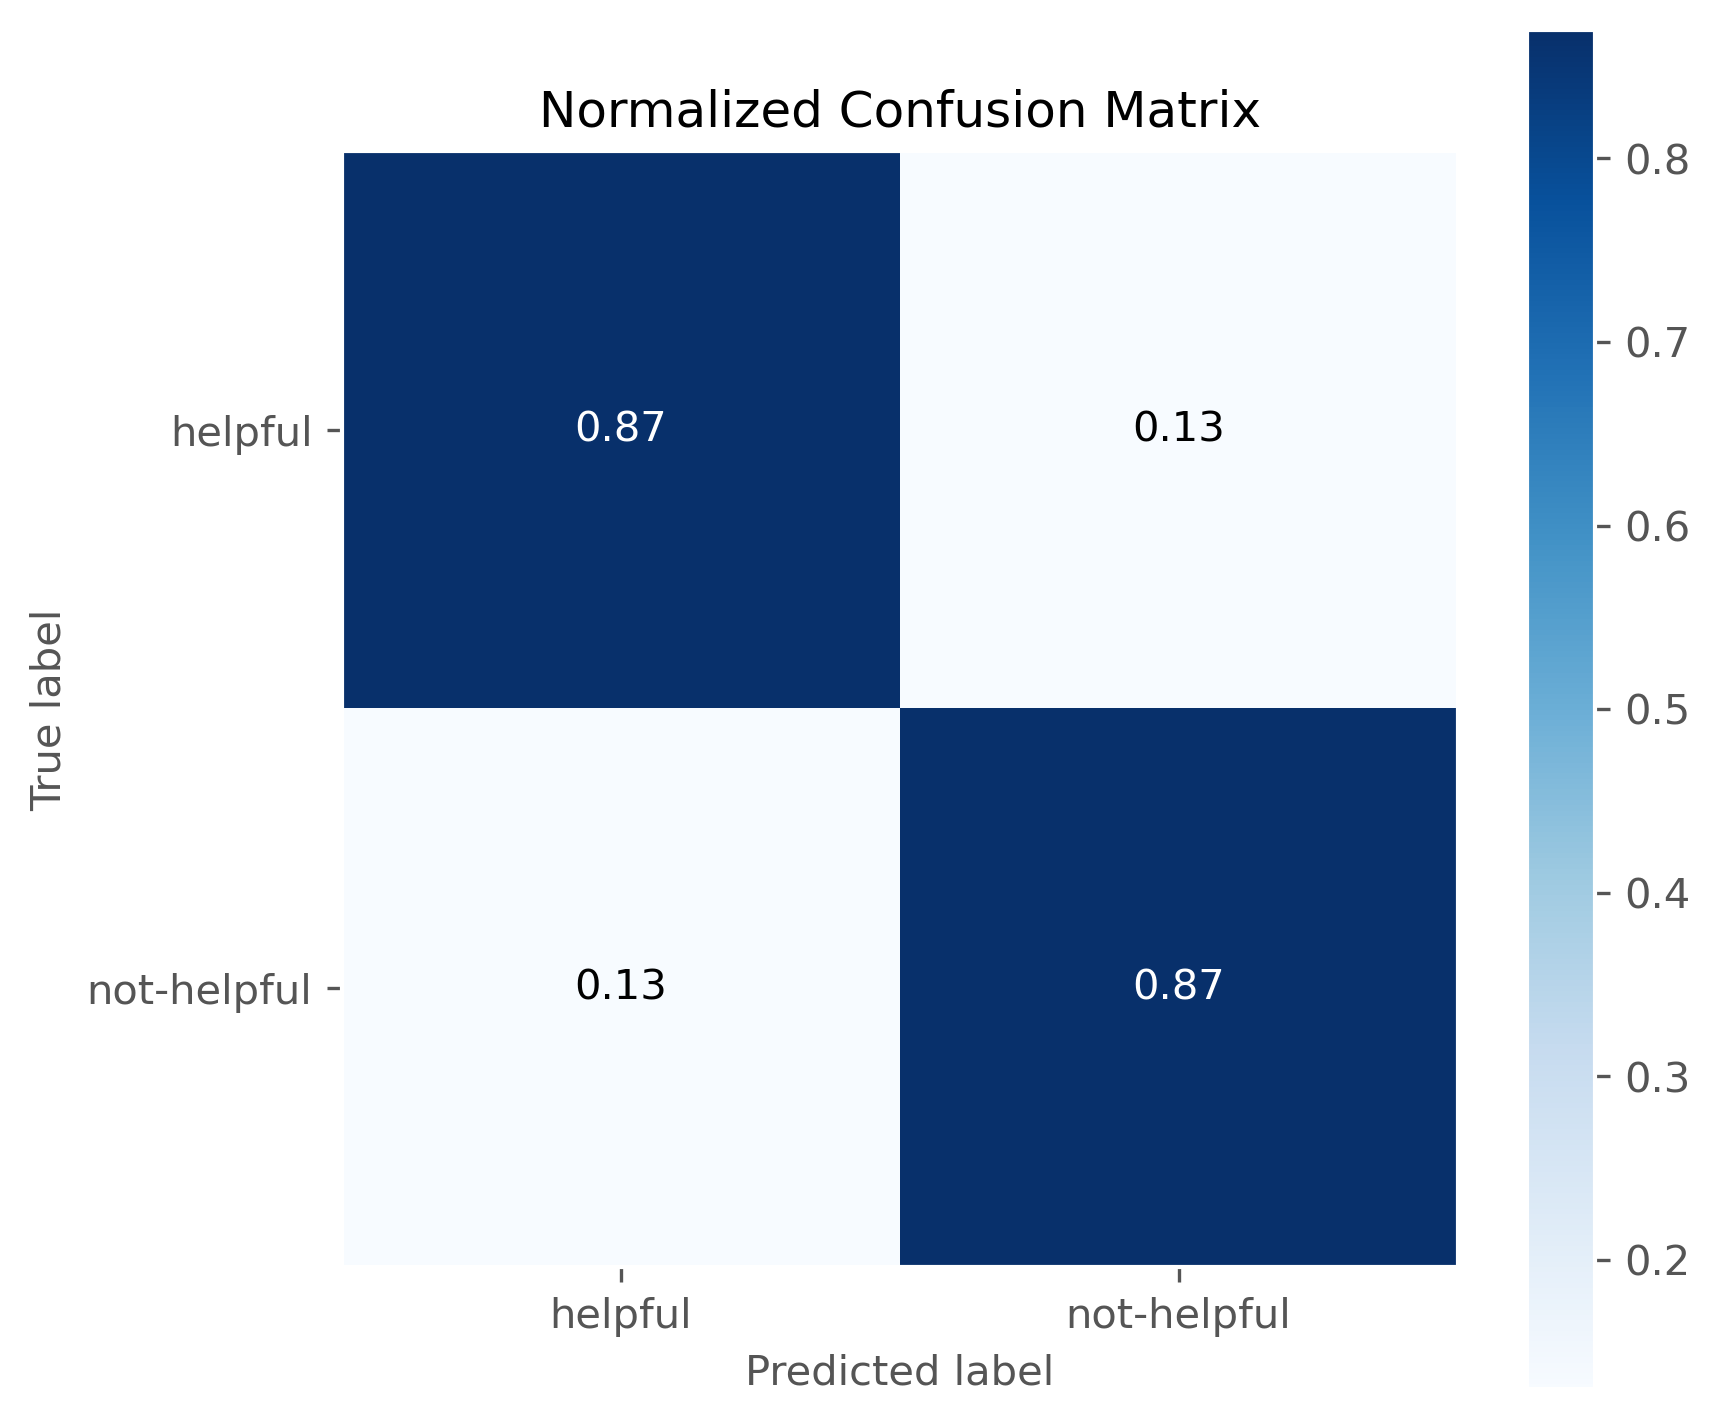

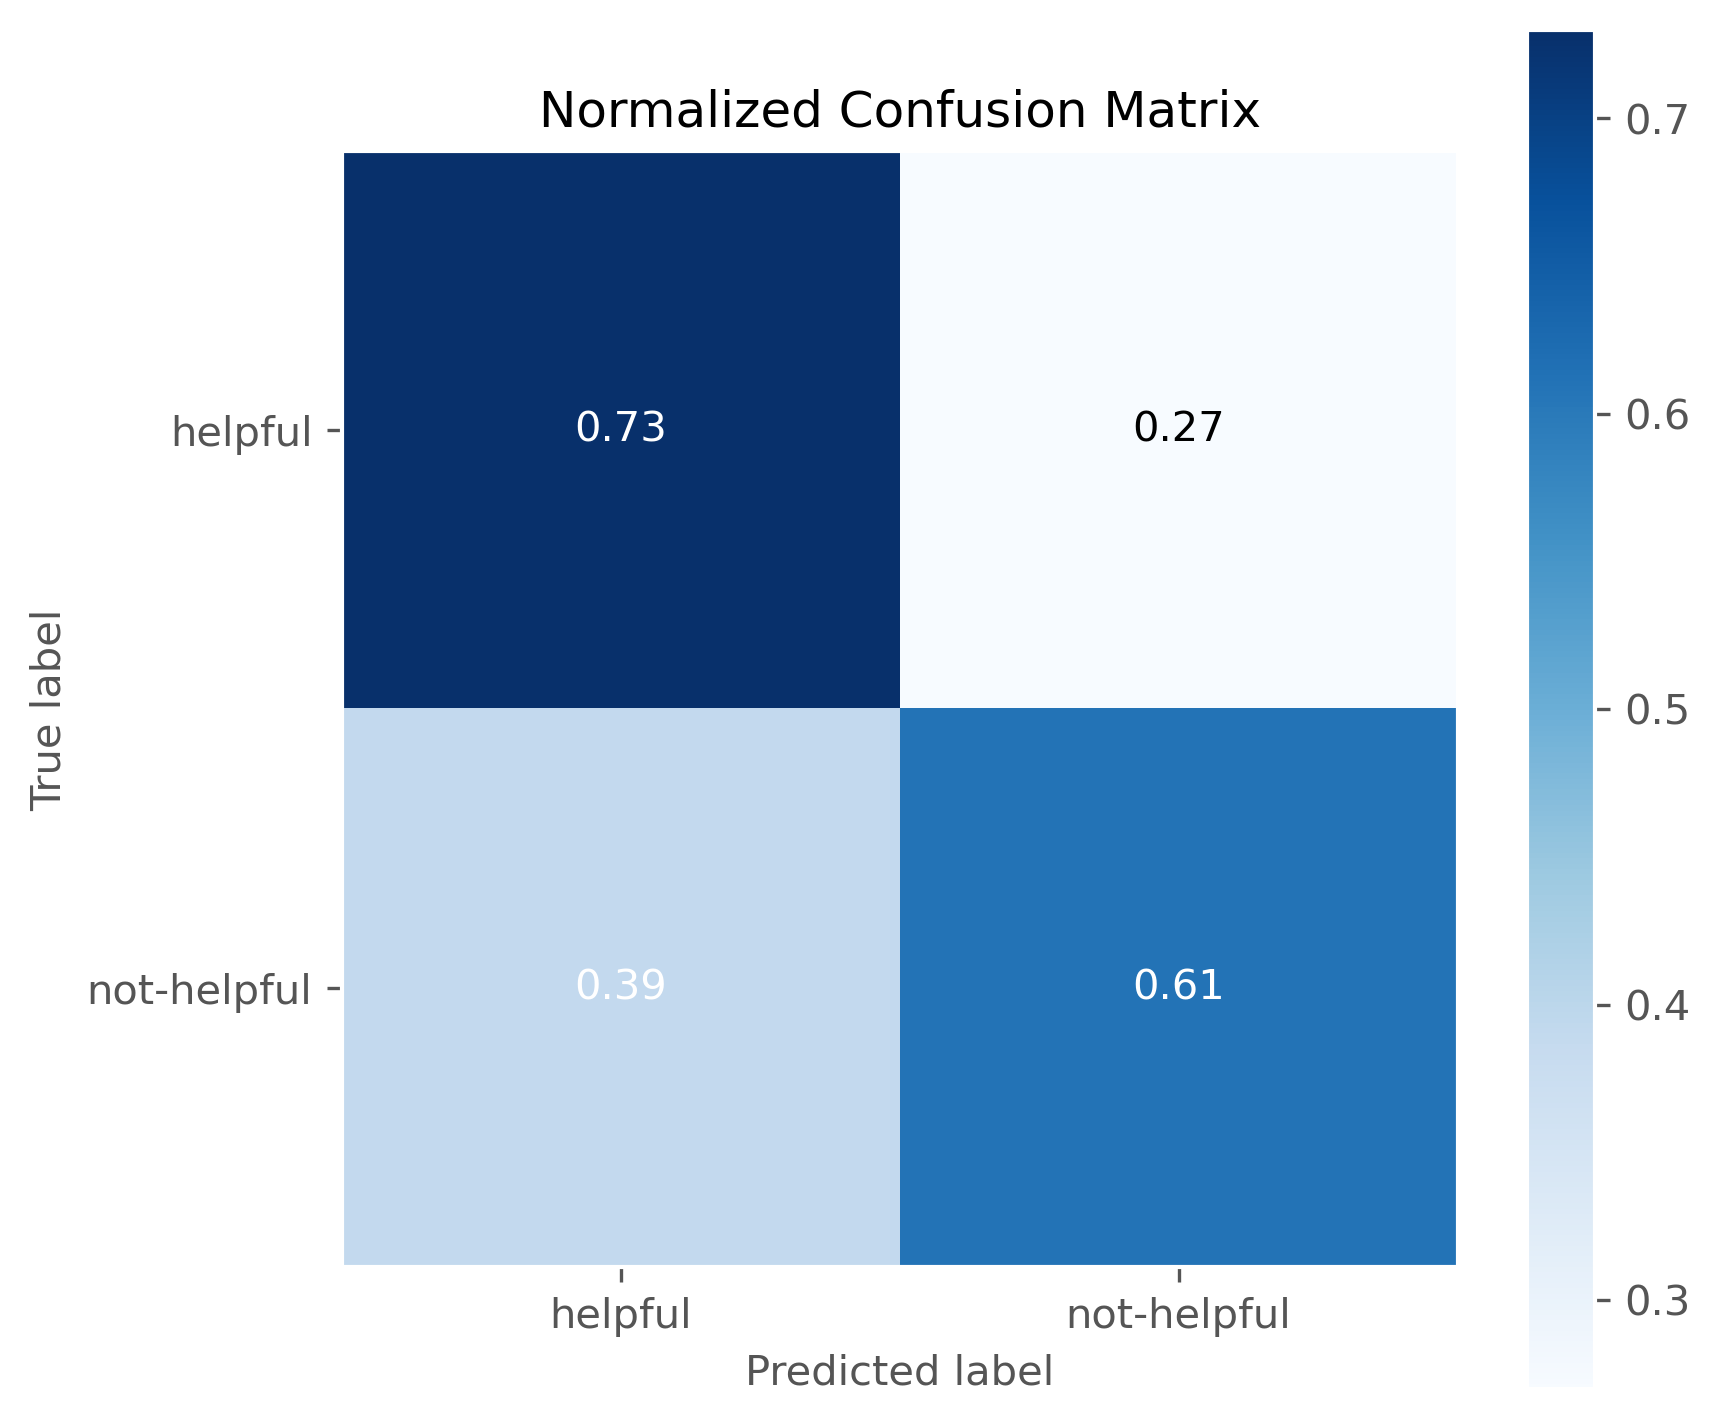

In [41]:
skplt.metrics.plot_confusion_matrix(y_train, predictions_train_n, normalize = 'all',  figsize=(6,6))
plt.show()
skplt.metrics.plot_confusion_matrix(y_test, predictions_test_n, normalize='all',figsize=(6,6))
plt.show()

True positives increased from 65% to 73% when compared to previous best unigram model, true negatives from 66% to 61%.

Interesting how the false positive rate has increased from 34% to 39%

## Checking Best C value

In [70]:
pipe_ngramc = make_pipeline(TfidfVectorizer(stop_words=stop),
                      LogisticRegression(multi_class='ovr',solver = 'saga', class_weight = 'balanced' ,
                                         max_iter = 5000, random_state=1),
                      )
params_ngramc = {'tfidfvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
                'tfidfvectorizer__lowercase': [True, False],
               'logisticregression__C': np.logspace(-4, 4, 9) }

gs_nlrc = GridSearchCV(pipe_ngramc, params_ngramc, scoring = 'f1_macro', cv=5, n_jobs=-2, verbose=3)

gs_nlrc.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
gs_nlrc.best_params_

In [ ]:
gs_nlrc.best_score_

Best c value (strenght of regularisation) is the default model setting

## Evaluate best logreg model - trigrams, lowercase=false

In [48]:
pipe = make_pipeline(TfidfVectorizer(ngram_range = (1,3), lowercase=False, stop_words = stop),
                      LogisticRegression(multi_class='ovr',solver = 'saga', max_iter = 1000, 
                                         class_weight = 'balanced', random_state=1))

pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words=['td', 'tr', 'th'])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='ovr', random_state=1,
                                    solver='saga'))])

In [49]:
importance = get_most_important_features(pipe['tfidfvectorizer'], pipe['logisticregression'], 10)

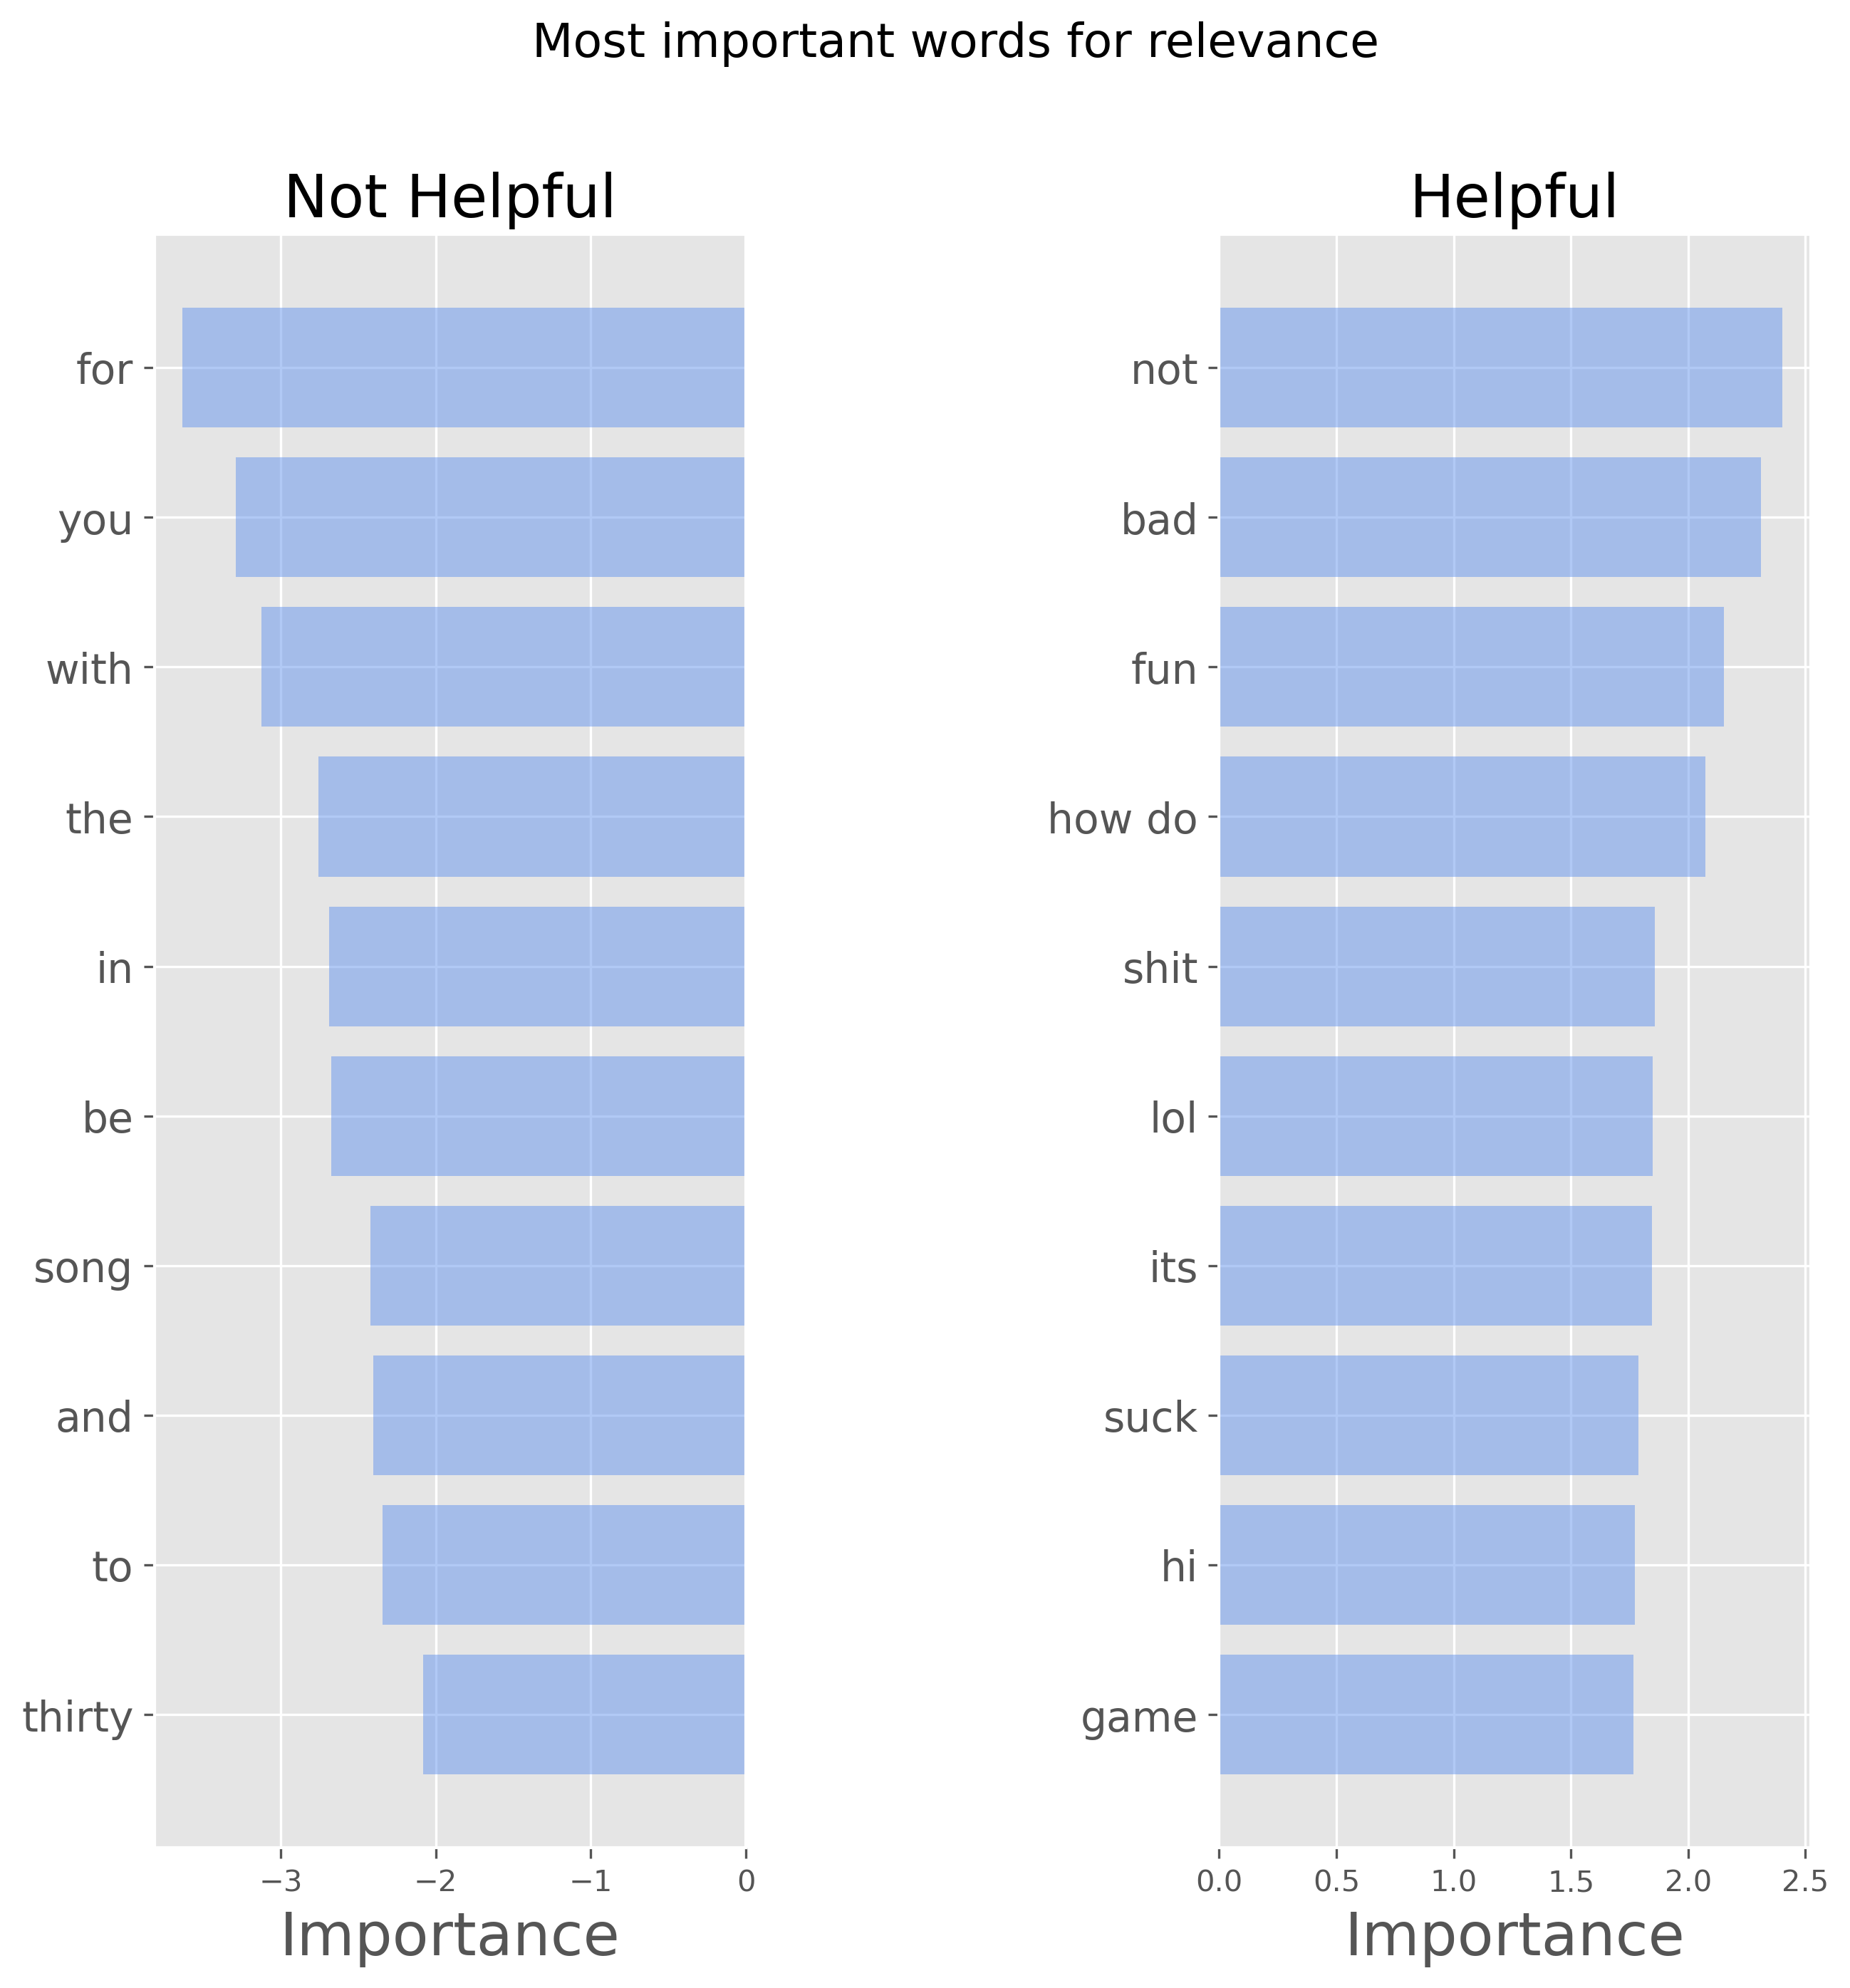

In [50]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Top and bottom coefficients have a lot more stop words and include a lot more unrelated terms.

Expand the view of coefficients

In [51]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(pipe['logisticregression'].coef_.T, index=pipe['tfidfvectorizer'].get_feature_names(),
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values('coefficients', ascending=False).head(30)

,coefficients,coef_abs
not,2.401779,2.401779
bad,2.309788,2.309788
fun,2.153267,2.153267
how do,2.074442,2.074442
shit,1.857277,1.857277
lol,1.848728,1.848728
its,1.846448,1.846448
suck,1.787402,1.787402
hi,1.771214,1.771214
game,1.767728,1.767728


### Precision-recall and ROC curve

In [45]:
probabilities_train = pipe.predict_proba(X_train)
probabilities_test = pipe.predict_proba(X_test)
cmap = ListedColormap(sns.color_palette("husl", len(pipe.classes_)))

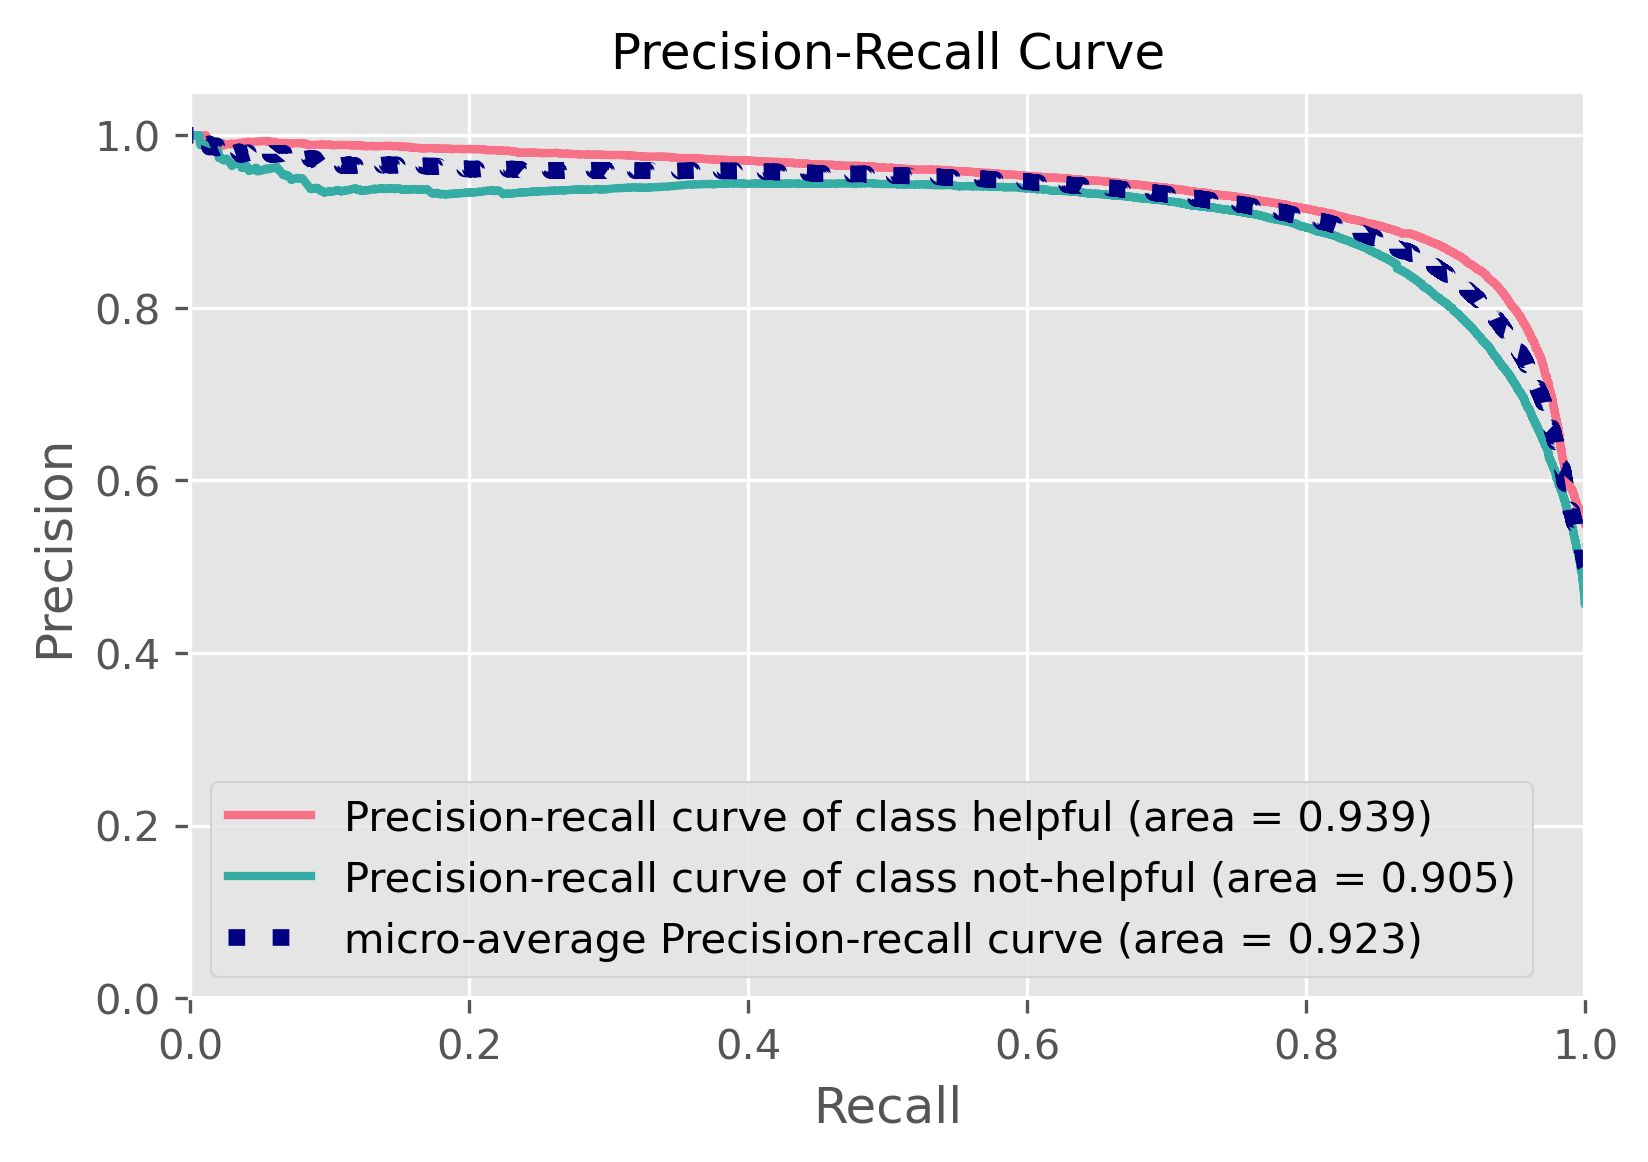

In [46]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train, cmap=cmap)
plt.show()

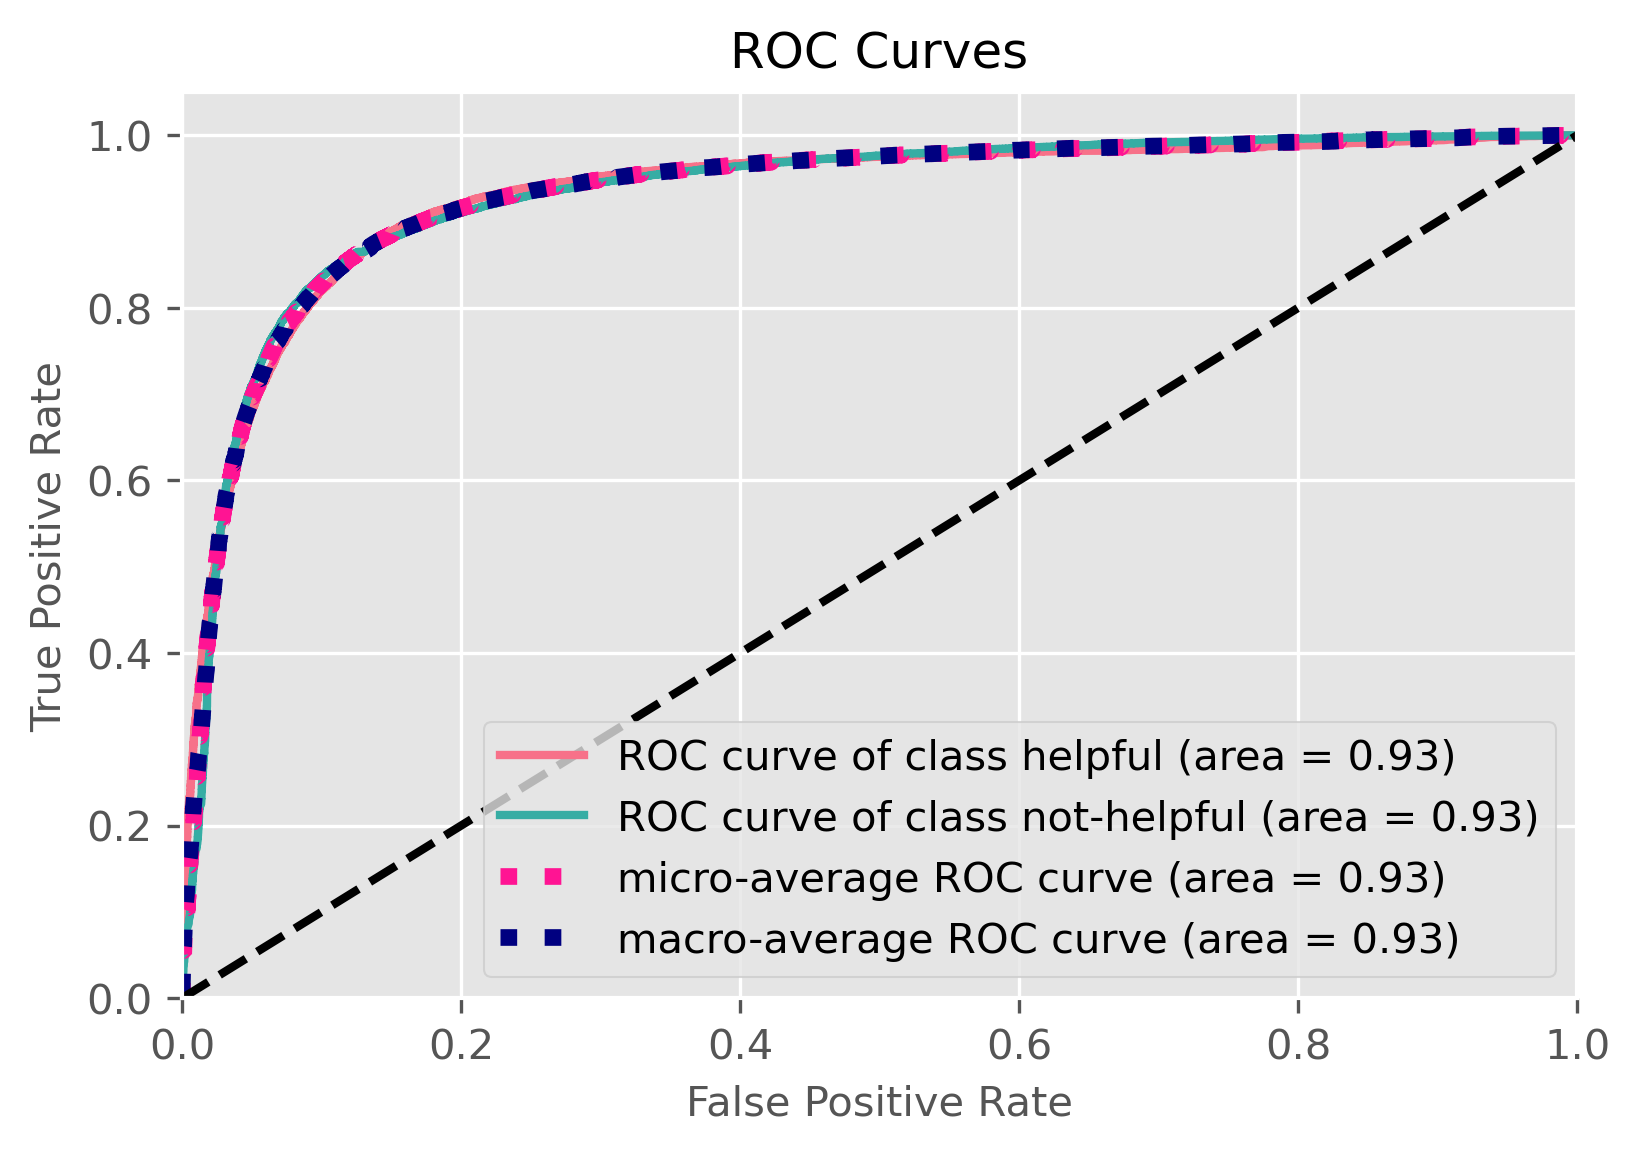

In [47]:
skplt.metrics.plot_roc(y_train, probabilities_train, cmap=cmap)
plt.show()

Roc curce shows improvement over the previous model.

Want to check the model with nltk stopwords

In [54]:
from nltk.corpus import stopwords
nltk_stop = stopwords.words('english')
nltk_stop.extend(['td', 'tr', 'th'])

In [55]:
pipe = make_pipeline(TfidfVectorizer(ngram_range = (1,3), lowercase=False, stop_words = nltk_stop),
                      LogisticRegression(multi_class='ovr',solver = 'saga', max_iter = 1000, 
                                         class_weight = 'balanced', random_state=1))

pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='ovr', random_state=1,
                                    solver='saga'))])

In [59]:
metrics.f1_score(y_test, pipe.predict(X_test),
                            average='macro')

0.6633371051504953

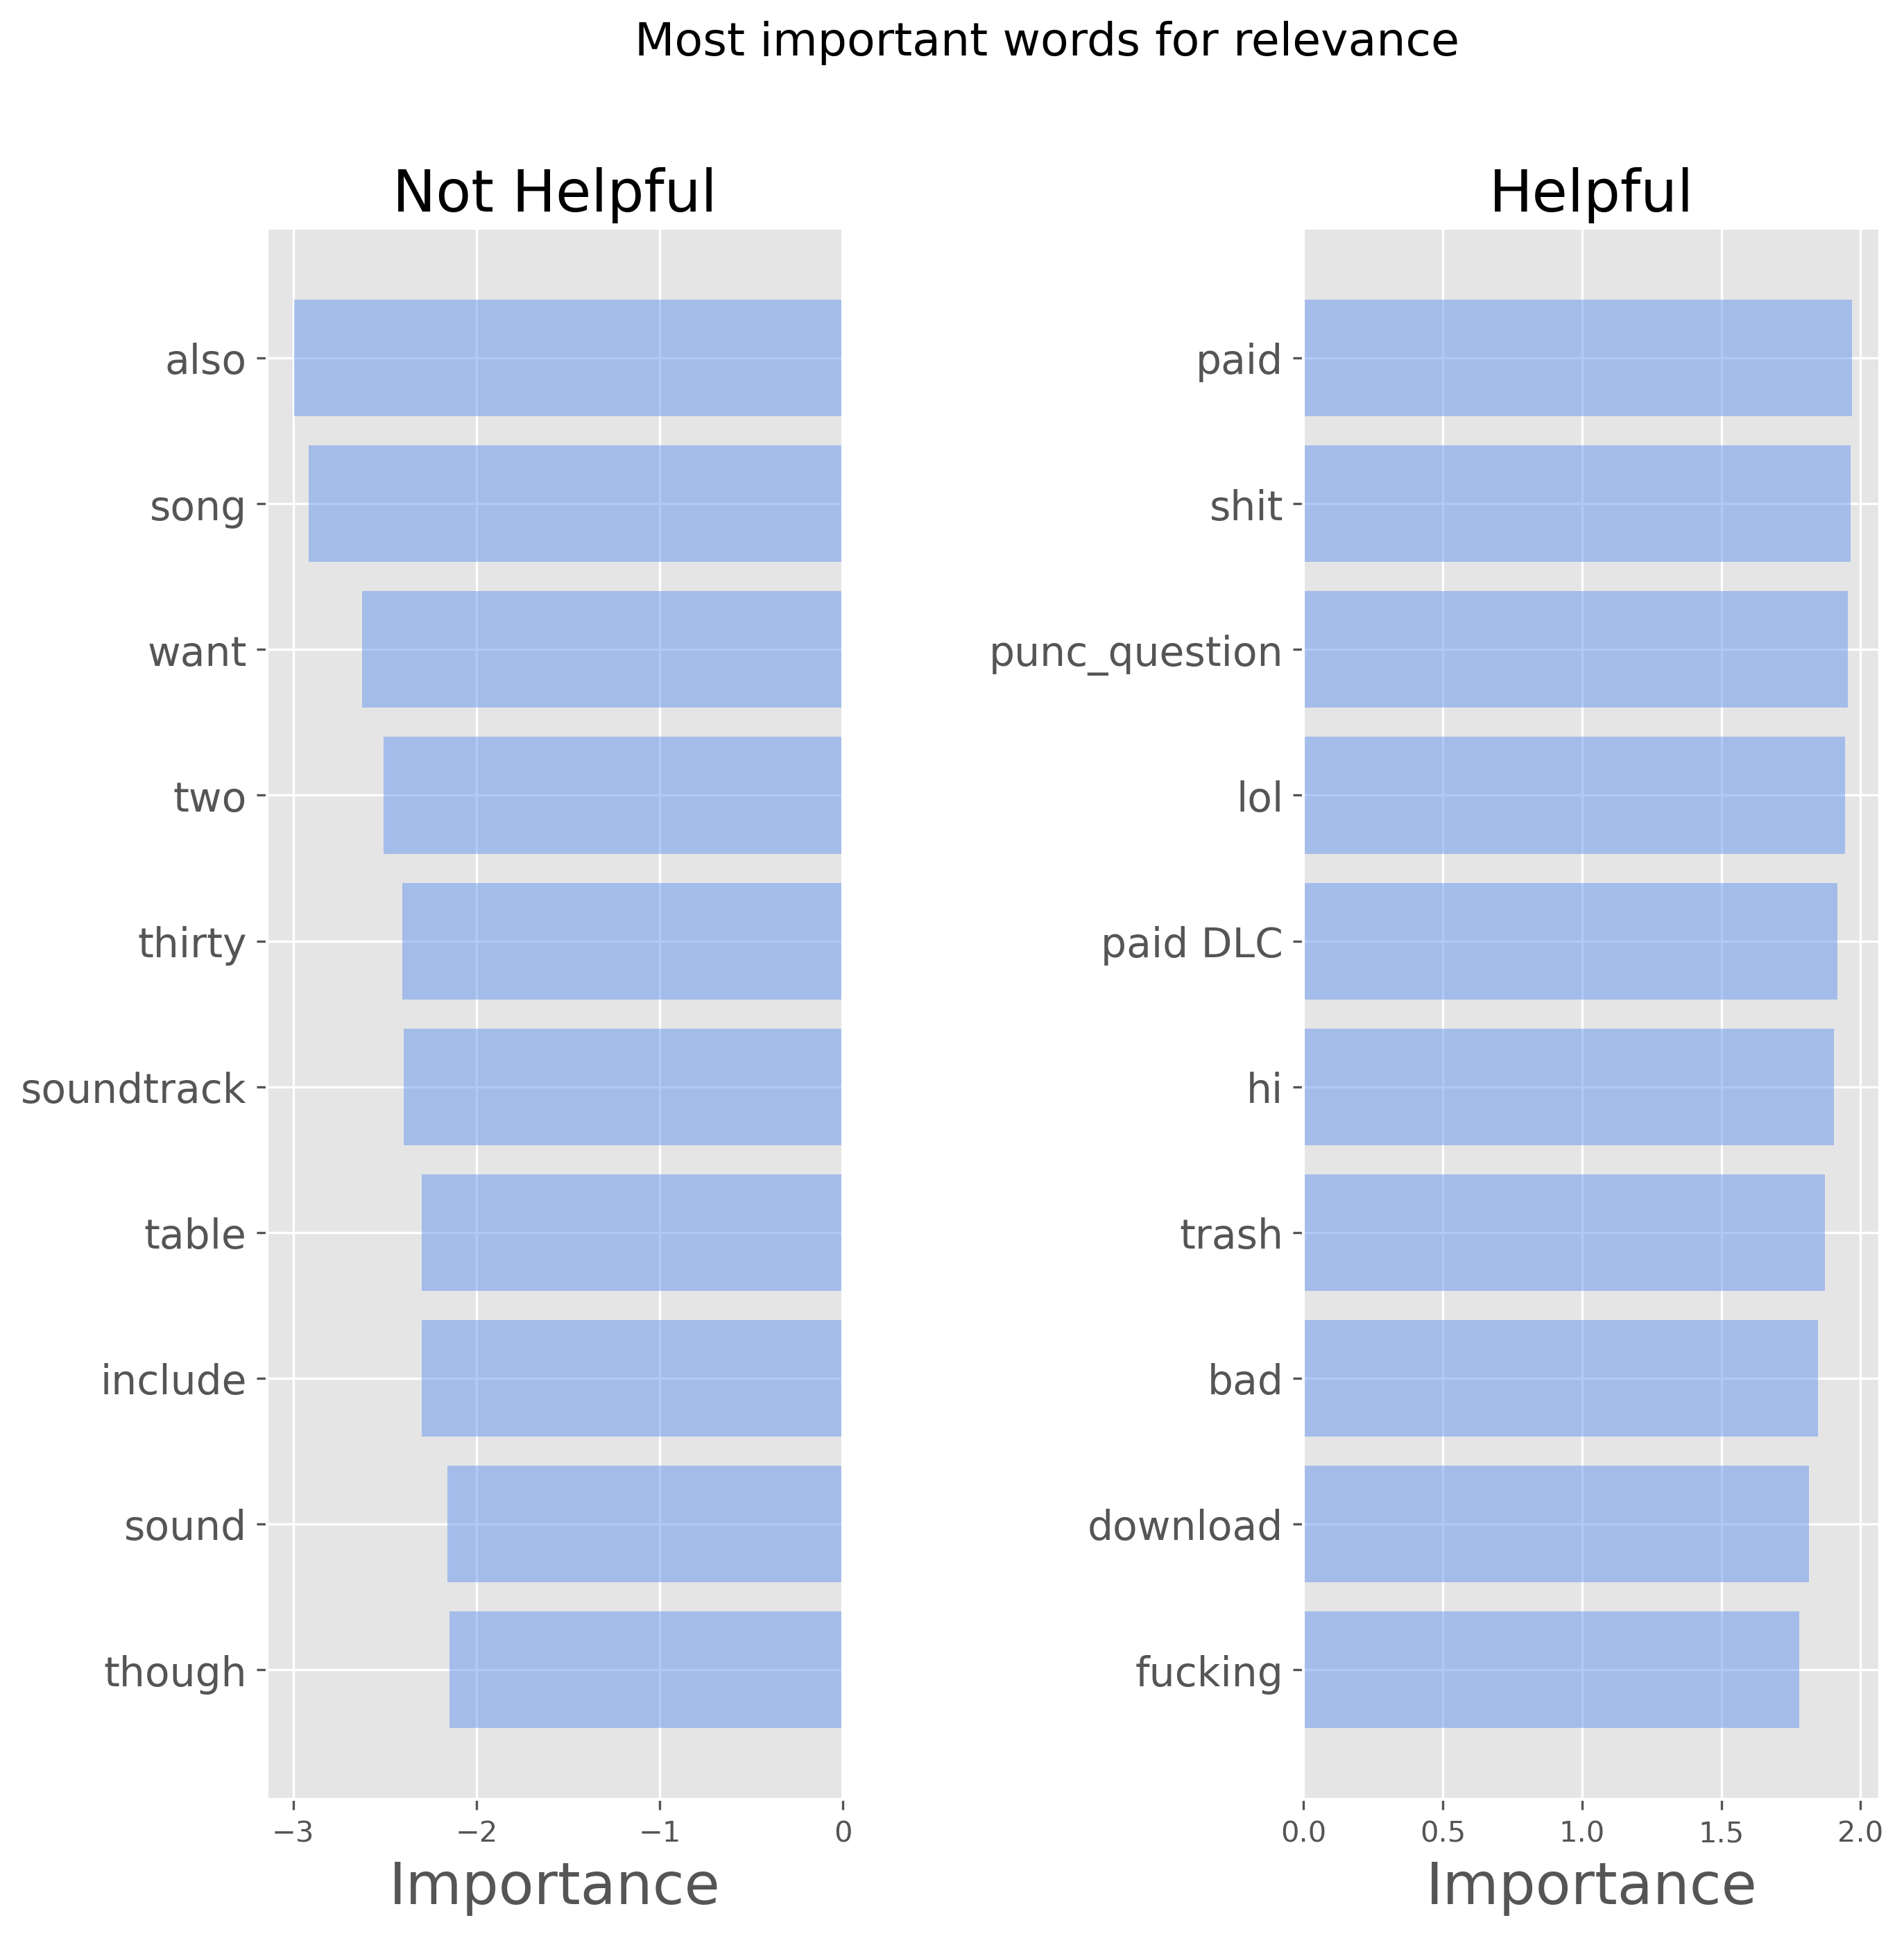

In [56]:
importance = get_most_important_features(pipe['tfidfvectorizer'], pipe['logisticregression'], 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

F1 score is only marginally worse (66.3 vs 66.9) but coefficients appear more useful.

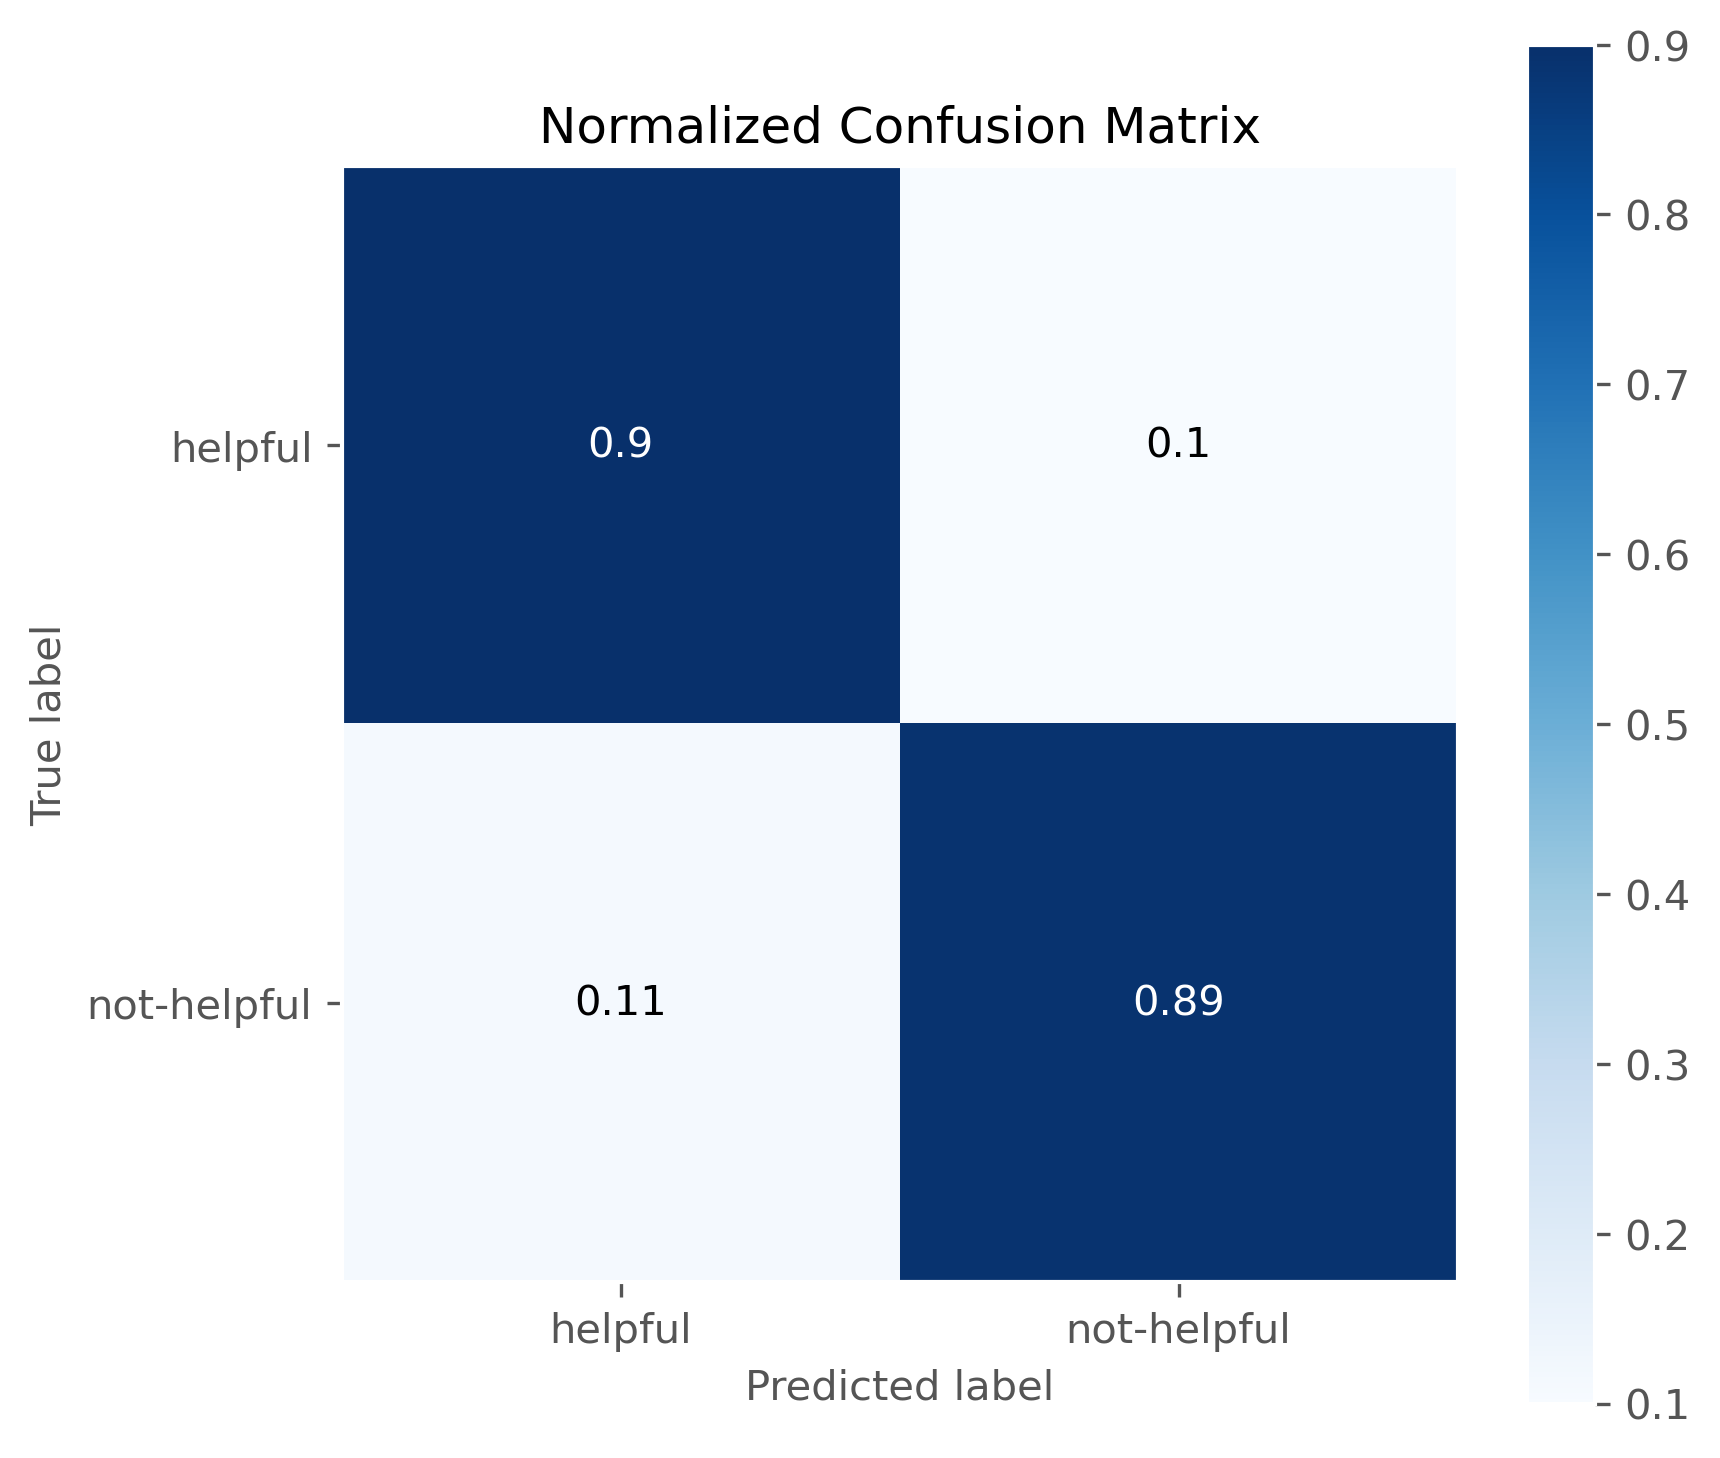

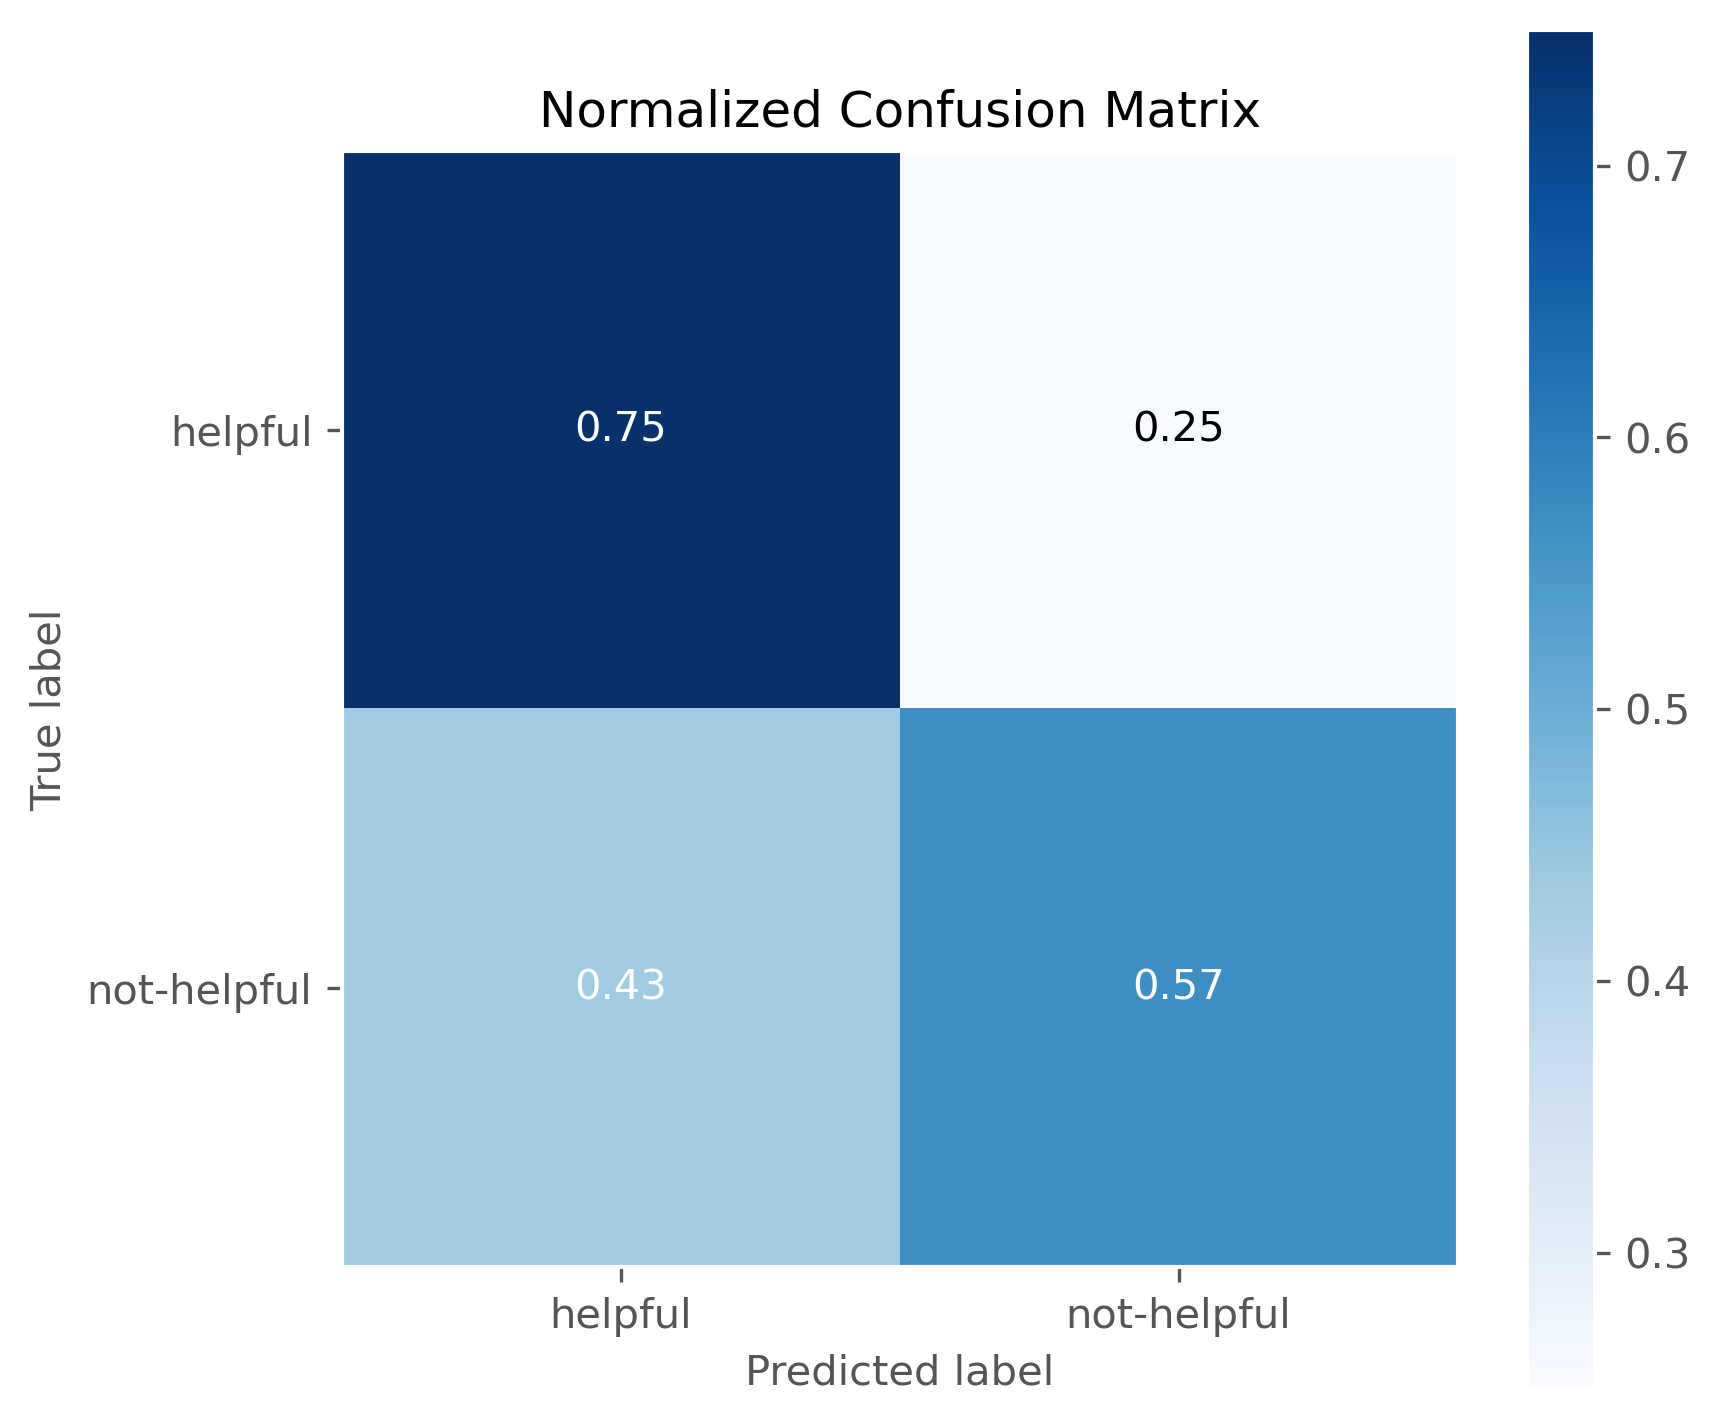

In [63]:
predictions_train_p, predictions_test_p =  pipe.predict(X_train), pipe.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_train, predictions_train_p, normalize = 'all',  figsize=(6,6))
plt.show()
skplt.metrics.plot_confusion_matrix(y_test, predictions_test_p, normalize='all',figsize=(6,6))
plt.show()

False positives have increased from 39% to 43% here - however as the coefficients seem more relevant will take the model without stopwords to be best in this instance.

# SGD Classifier

In [71]:
pipe_sgd = make_pipeline(TfidfVectorizer(stop_words= nltk_stop),
                        SGDClassifier(penalty = 'l2', loss='hinge', class_weight = 'balanced', random_state=1))

params_sgd = {'tfidfvectorizer__ngram_range' :[(1,1), (1,2), (1,3)],
             'tfidfvectorizer__lowercase':[True, False],
             'sgdclassifier__average' :[True, False],
             'sgdclassifier__alpha' : np.power(10, np.arange(-4,1,dtype=float))}

#the higher the alpha the stronger the regularization

gs_sgd = GridSearchCV(pipe_sgd, params_sgd, scoring='f1_macro', cv=5, n_jobs=-2, verbose=3)
gs_sgd.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['td', 'tr',
                                                                    'th'])),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      random_state=1))]),
             n_jobs=-2,
             param_grid={'sgdclassifier__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'sgdclassifier__average': [True, False],
                         'tfidfvectorizer__lowercase': [True, False],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             scoring='f1_macro', verbose=3)

In [72]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [73]:
report(gs_sgd.cv_results_)

Model with rank: 1
Mean validation score: 0.660 (std: 0.007)
Parameters: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__average': True, 'tfidfvectorizer__lowercase': True, 'tfidfvectorizer__ngram_range': (1, 3)}

Model with rank: 2
Mean validation score: 0.659 (std: 0.007)
Parameters: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__average': False, 'tfidfvectorizer__lowercase': True, 'tfidfvectorizer__ngram_range': (1, 3)}

Model with rank: 3
Mean validation score: 0.659 (std: 0.006)
Parameters: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__average': True, 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__ngram_range': (1, 3)}



In Logreg the default C yields best results and in SGD the default alpha value.

Mean score is 66% vs 66.3% for the best logreg model

## Evaluating best SGD model

In [77]:
pipe = make_pipeline(TfidfVectorizer(ngram_range = (1,3), stop_words = nltk_stop),
                      SGDClassifier(penalty = 'l2', loss='hinge', average=True,
                                         class_weight = 'balanced', random_state=1))

pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('sgdclassifier',
                 SGDClassifier(average=True, class_weight='balanced',
                               random_state=1))])

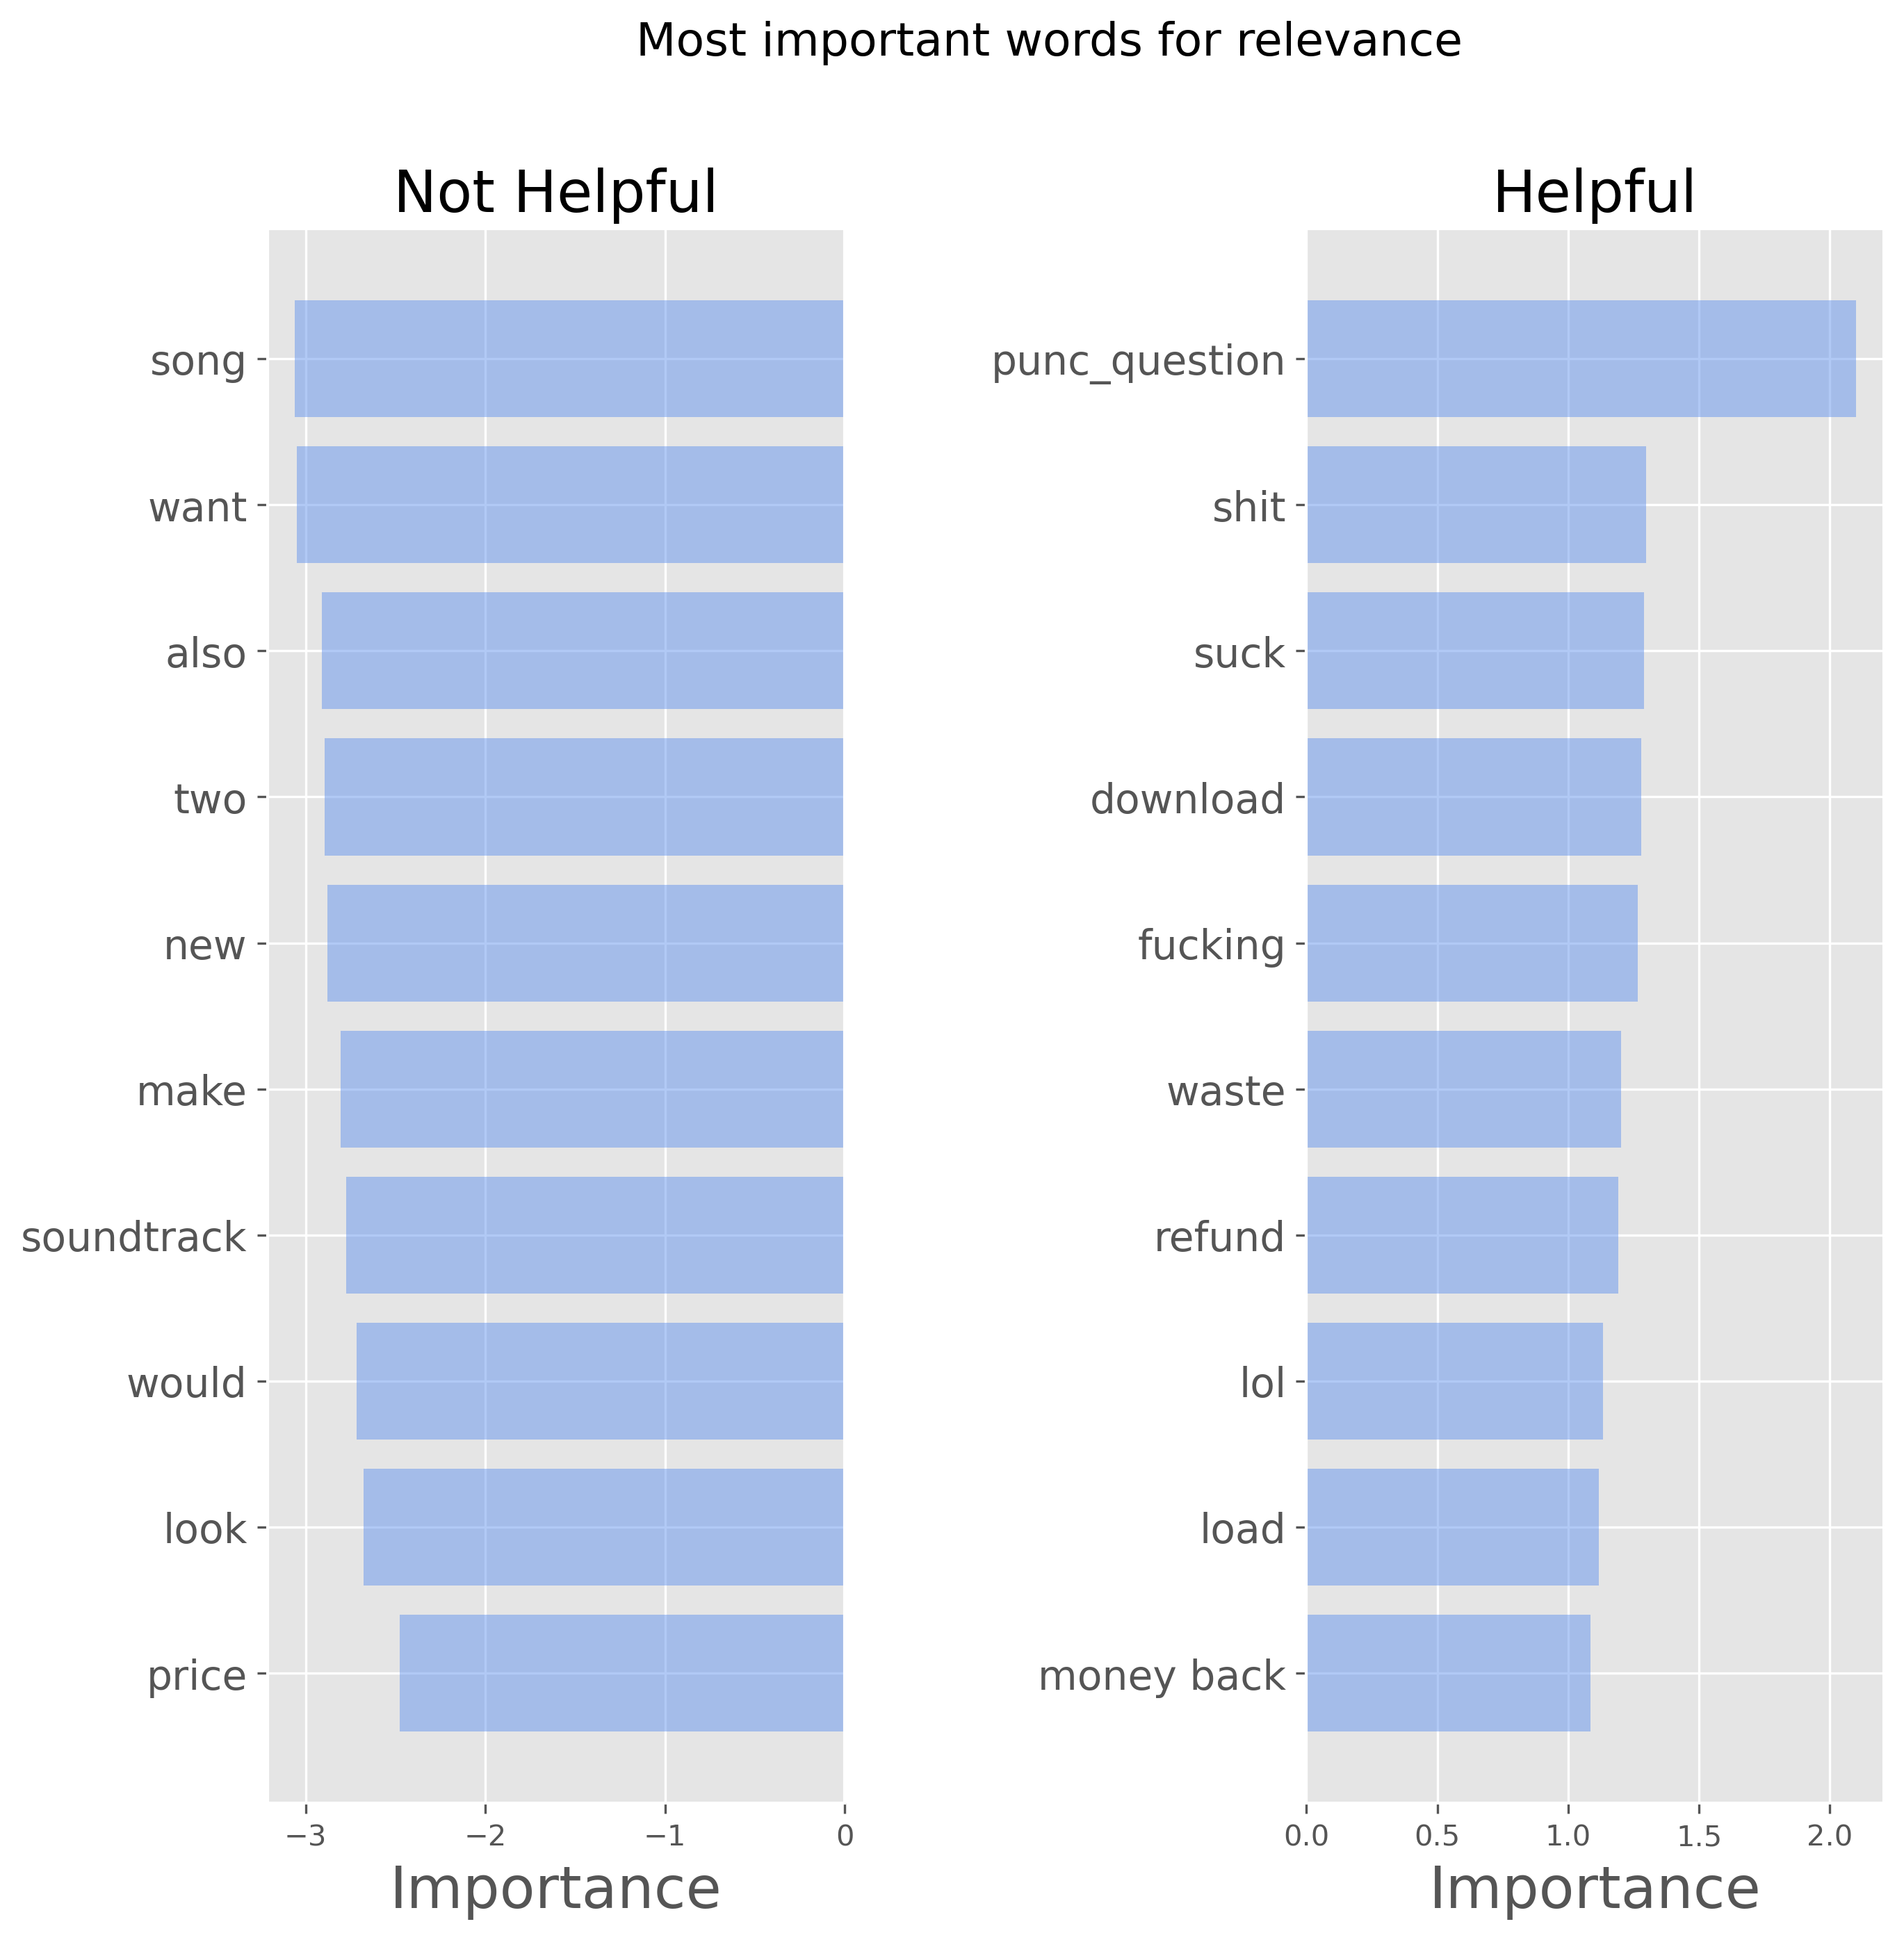

In [78]:
importance = get_most_important_features(pipe['tfidfvectorizer'], pipe['sgdclassifier'], 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

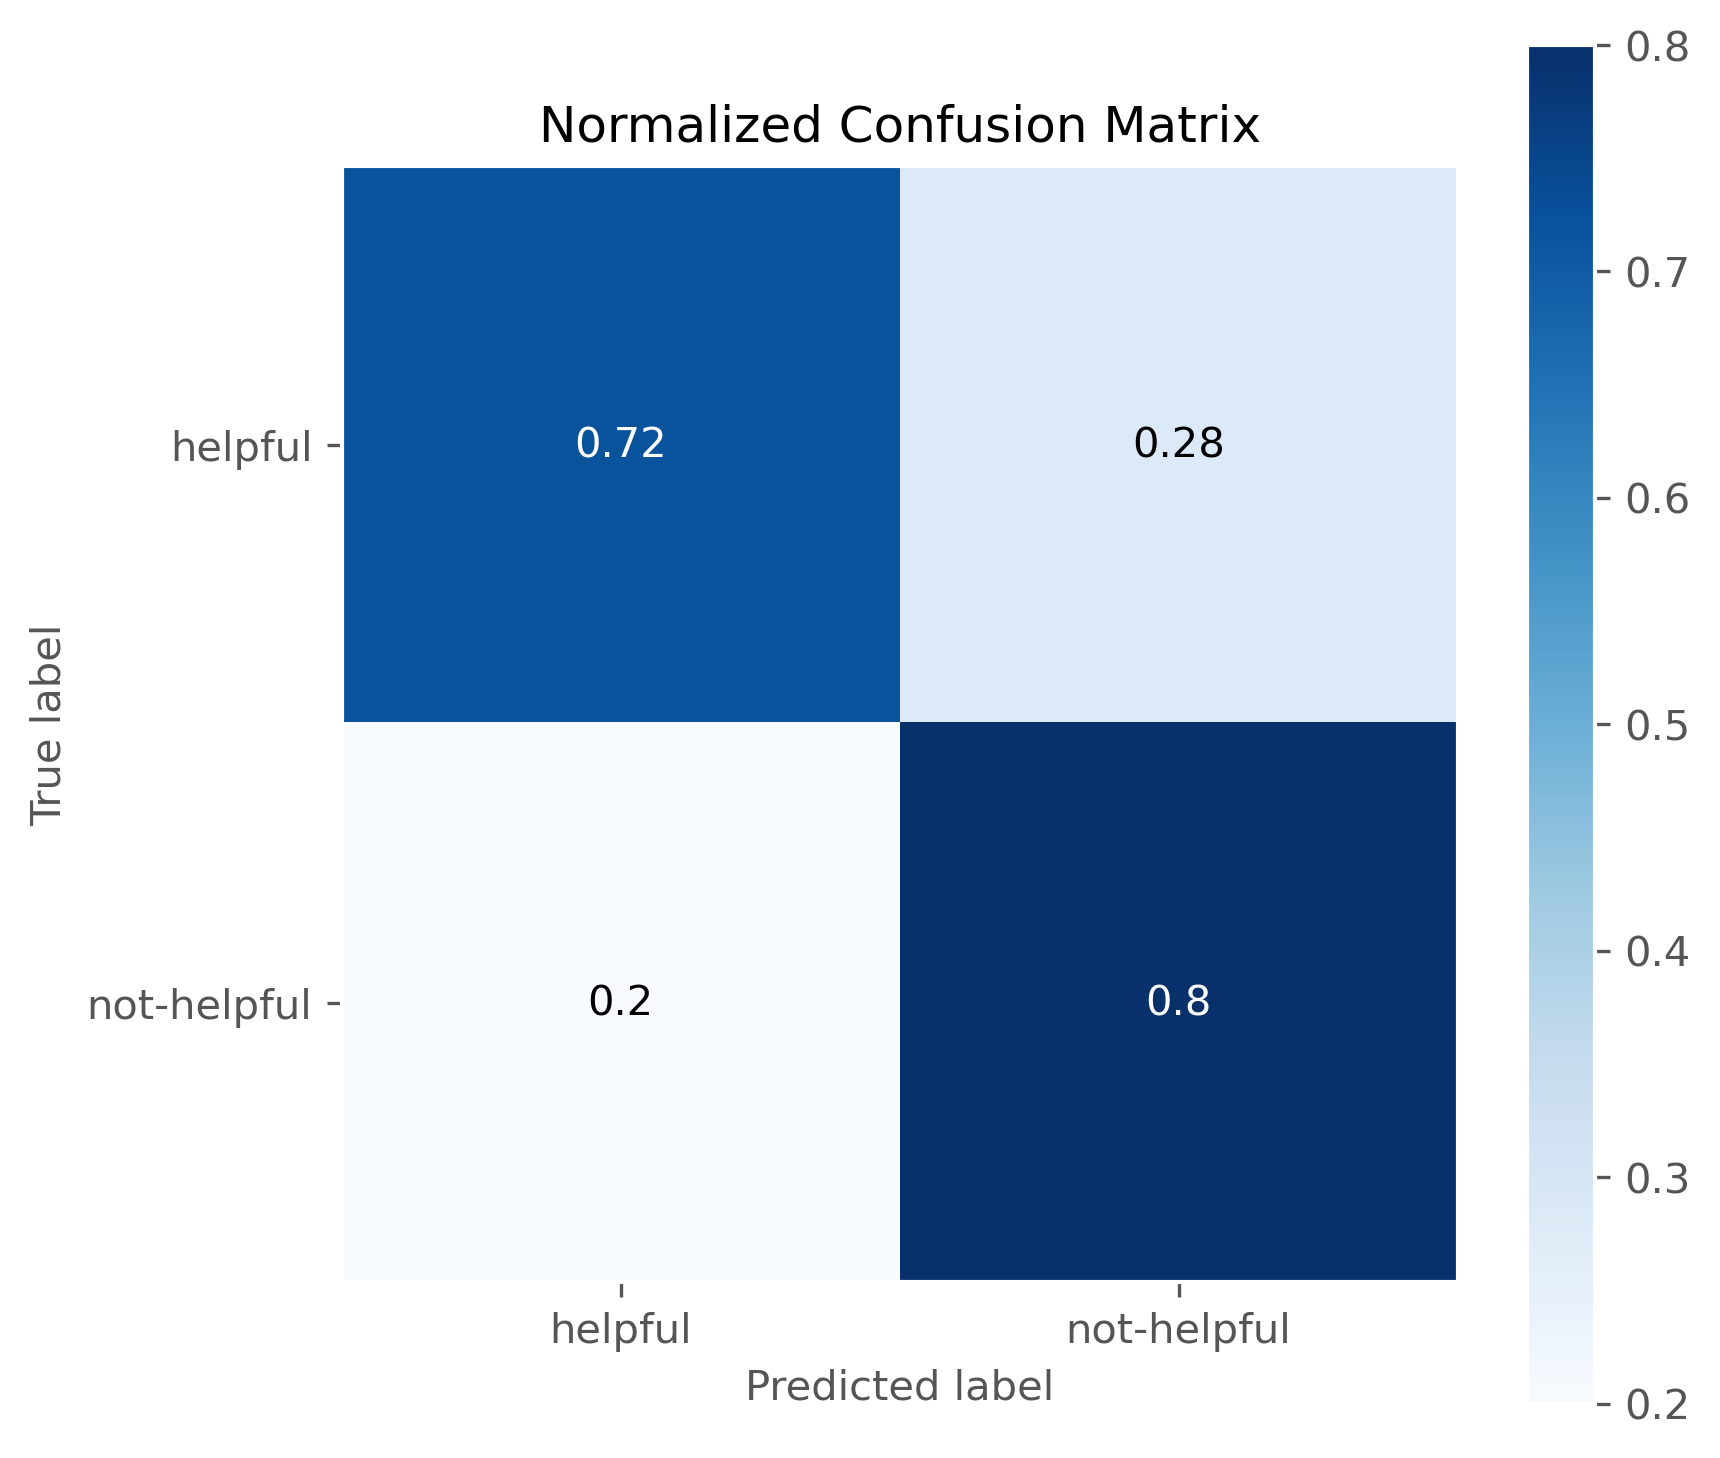

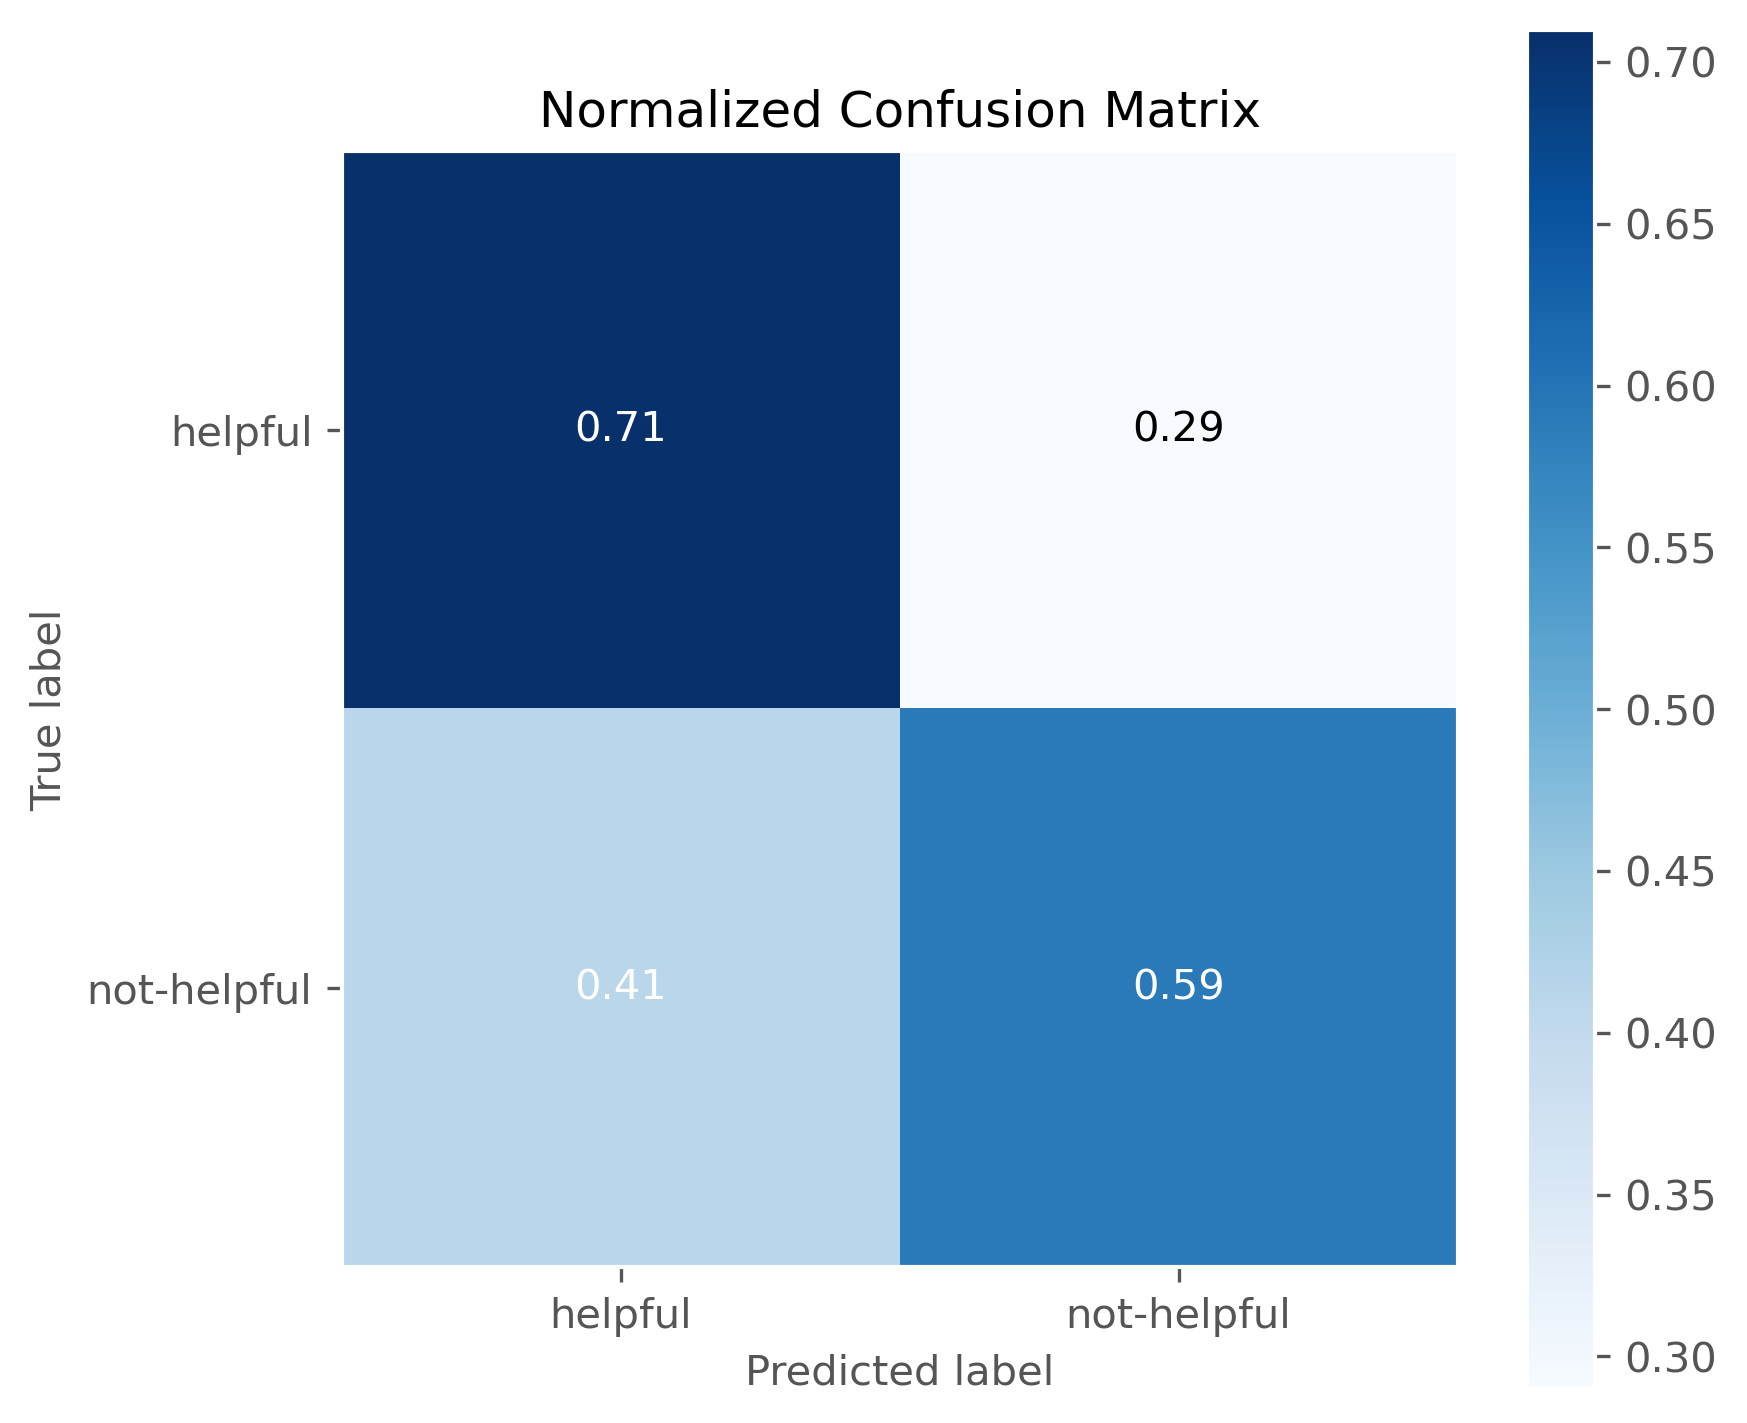

In [79]:
predictions_train_sgd, predictions_test_sgd =  pipe.predict(X_train), pipe.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_train, predictions_train_sgd, normalize = 'all',  figsize=(6,6))
plt.show()
skplt.metrics.plot_confusion_matrix(y_test, predictions_test_sgd, normalize='all',figsize=(6,6))
plt.show()

Performs pretty similarly to the Logistic Regression model with slightly less false positives but more false negatives. 

Coefficients for both models in the helpful class seem more related to negative reviews even though there are more positive reviews overall.

SGD classifier model also gives high importance to question marks, i'll try removing this and see how the model performs.

In [80]:
new_stop = nltk_stop + ['punc_question']

In [82]:
pipe = make_pipeline(TfidfVectorizer(ngram_range = (1,3), stop_words = new_stop),
                      SGDClassifier(penalty = 'l2', loss='hinge', average=True,
                                         class_weight = 'balanced', random_state=1))

pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('sgdclassifier',
                 SGDClassifier(average=True, class_weight='balanced',
                               random_state=1))])

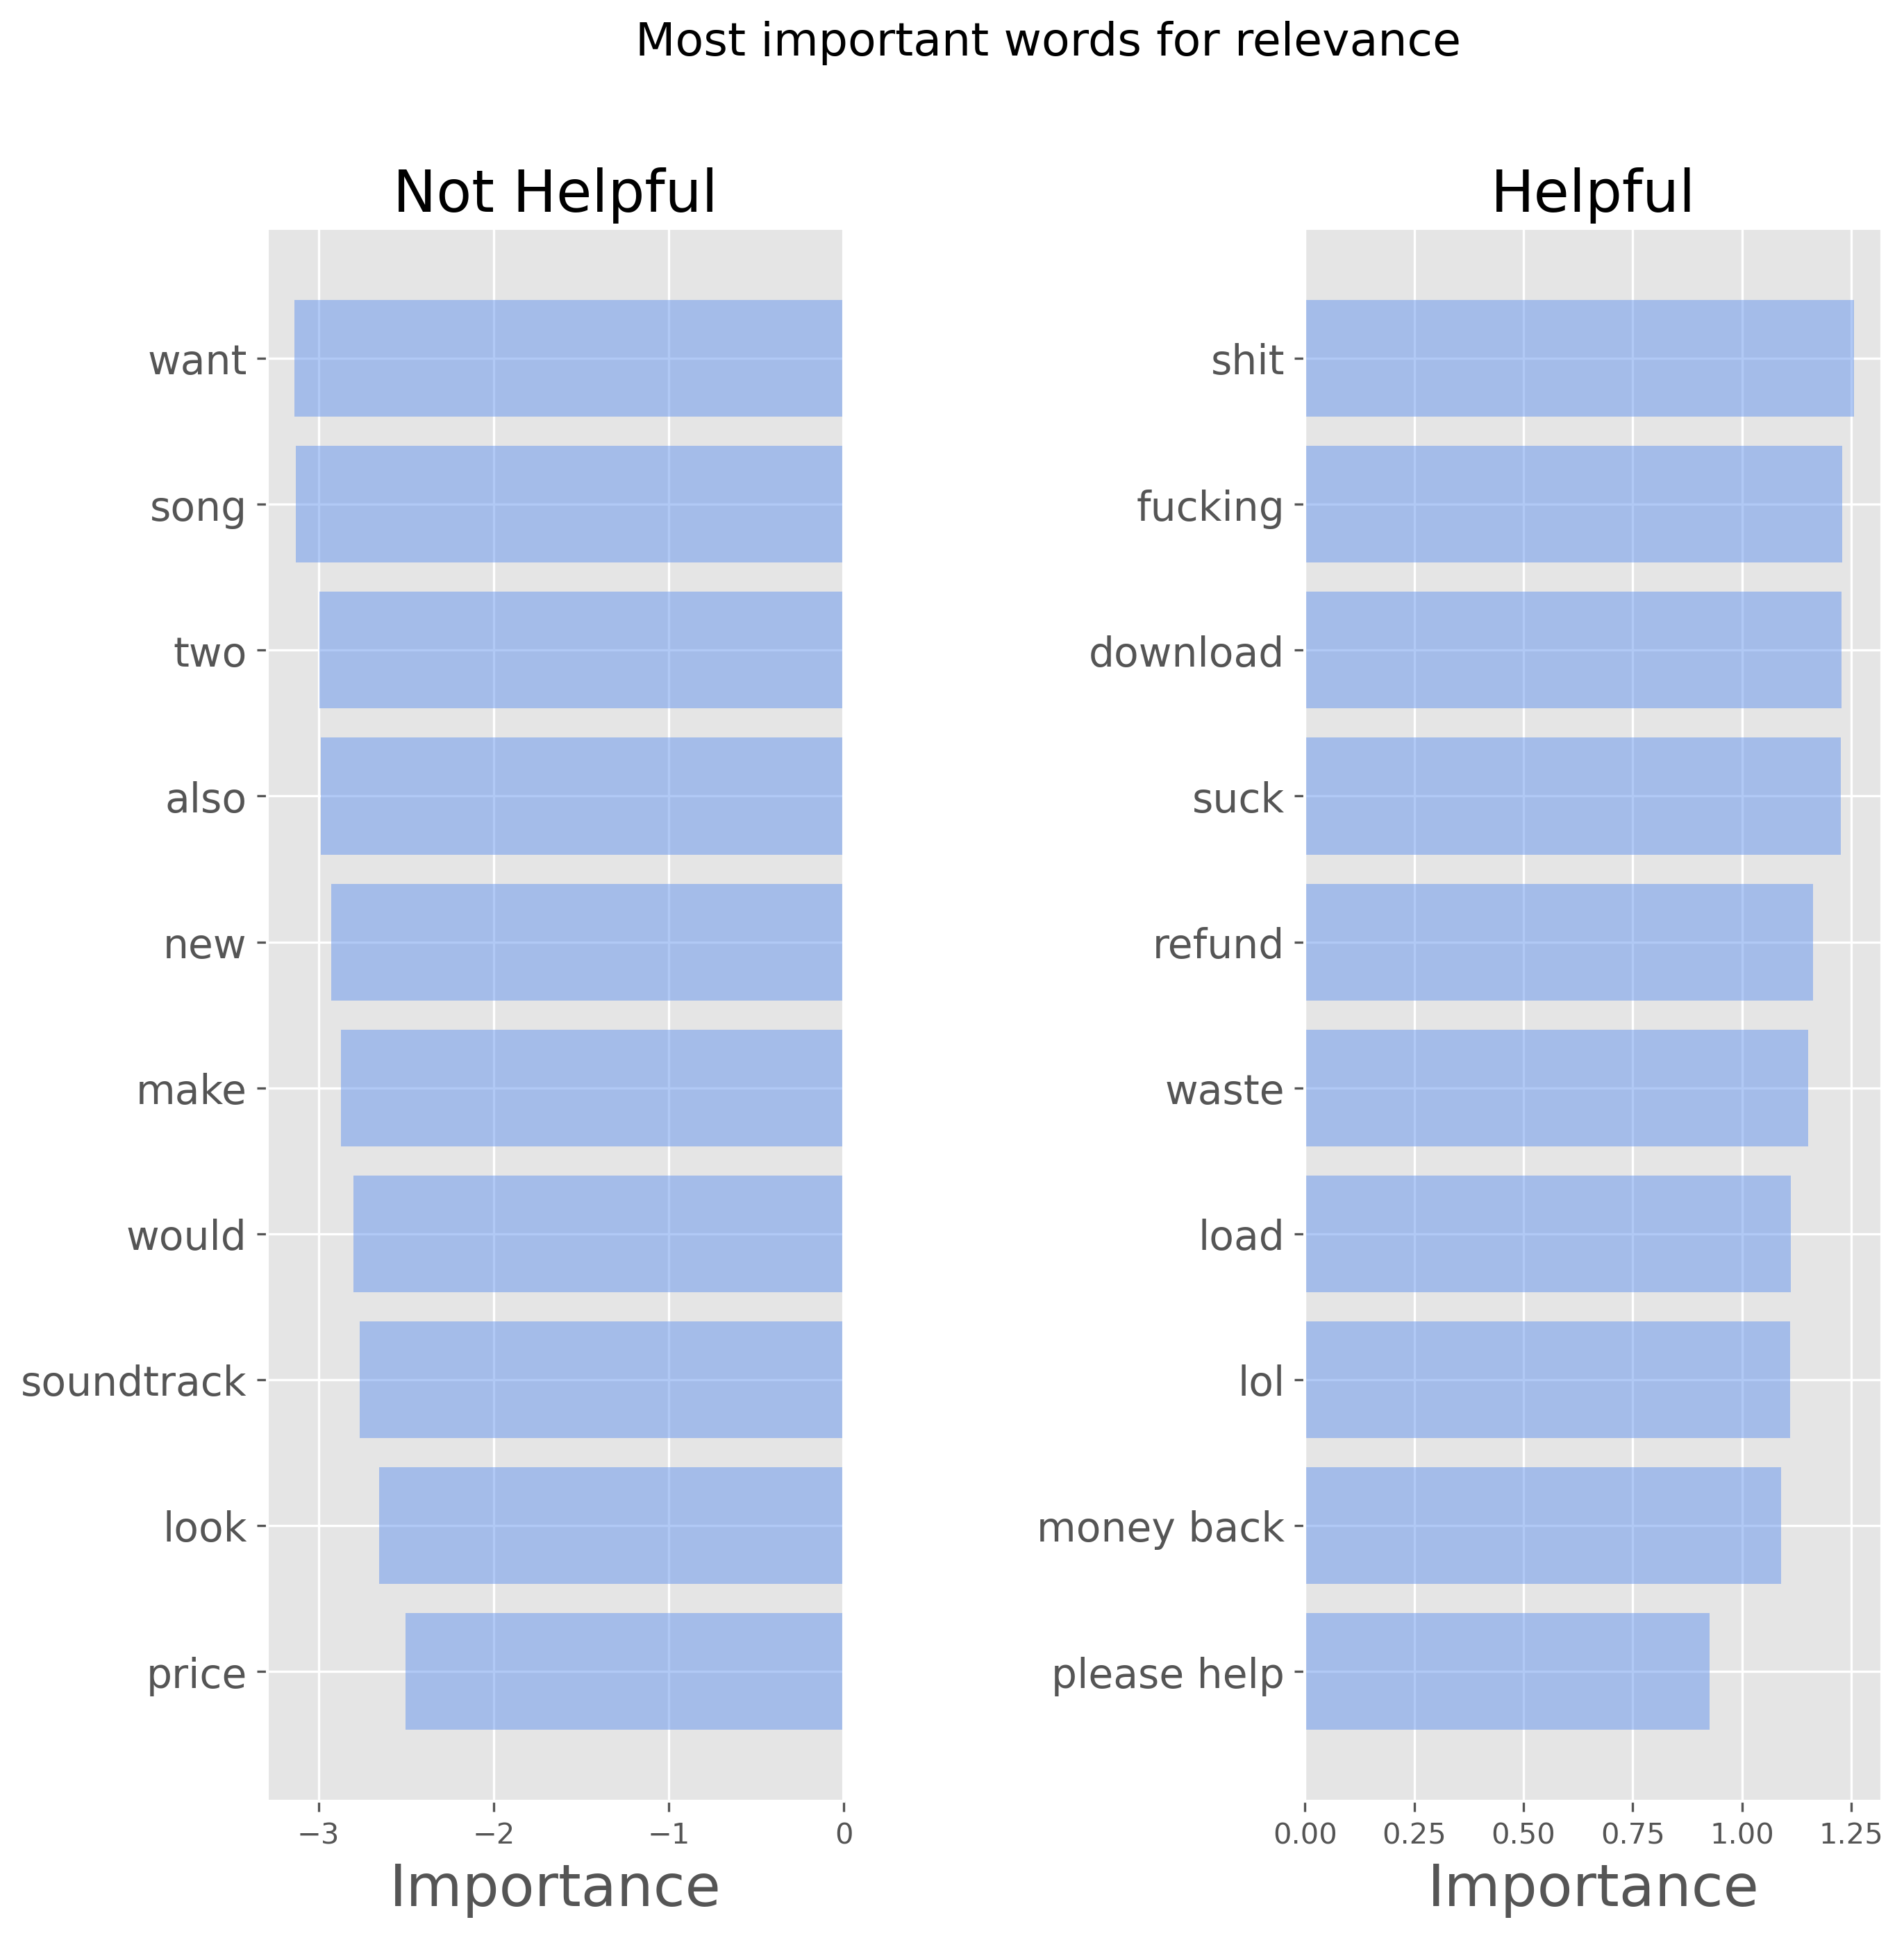

In [83]:
importance = get_most_important_features(pipe['tfidfvectorizer'], pipe['sgdclassifier'], 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

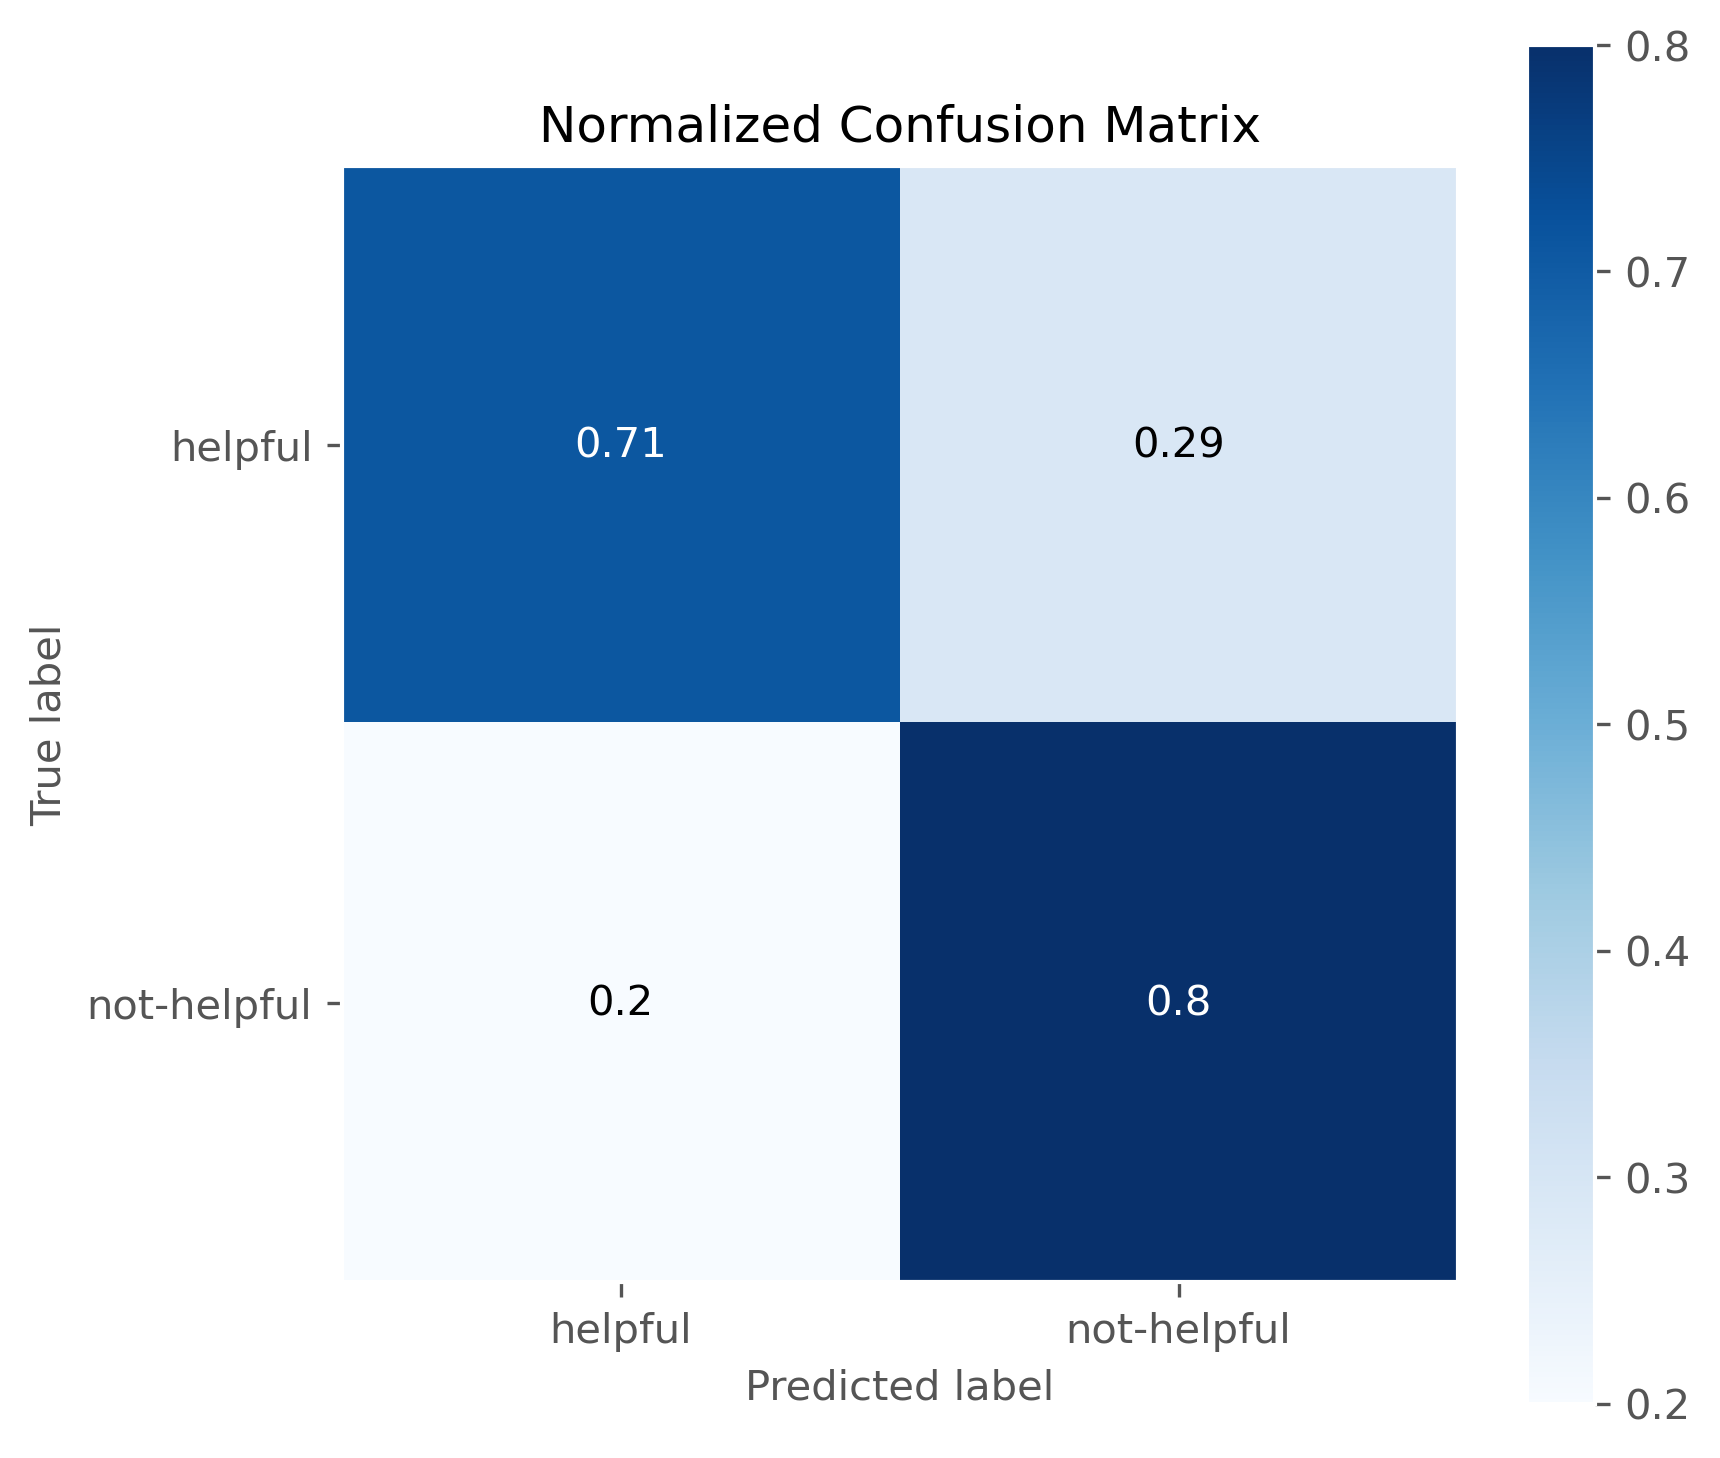

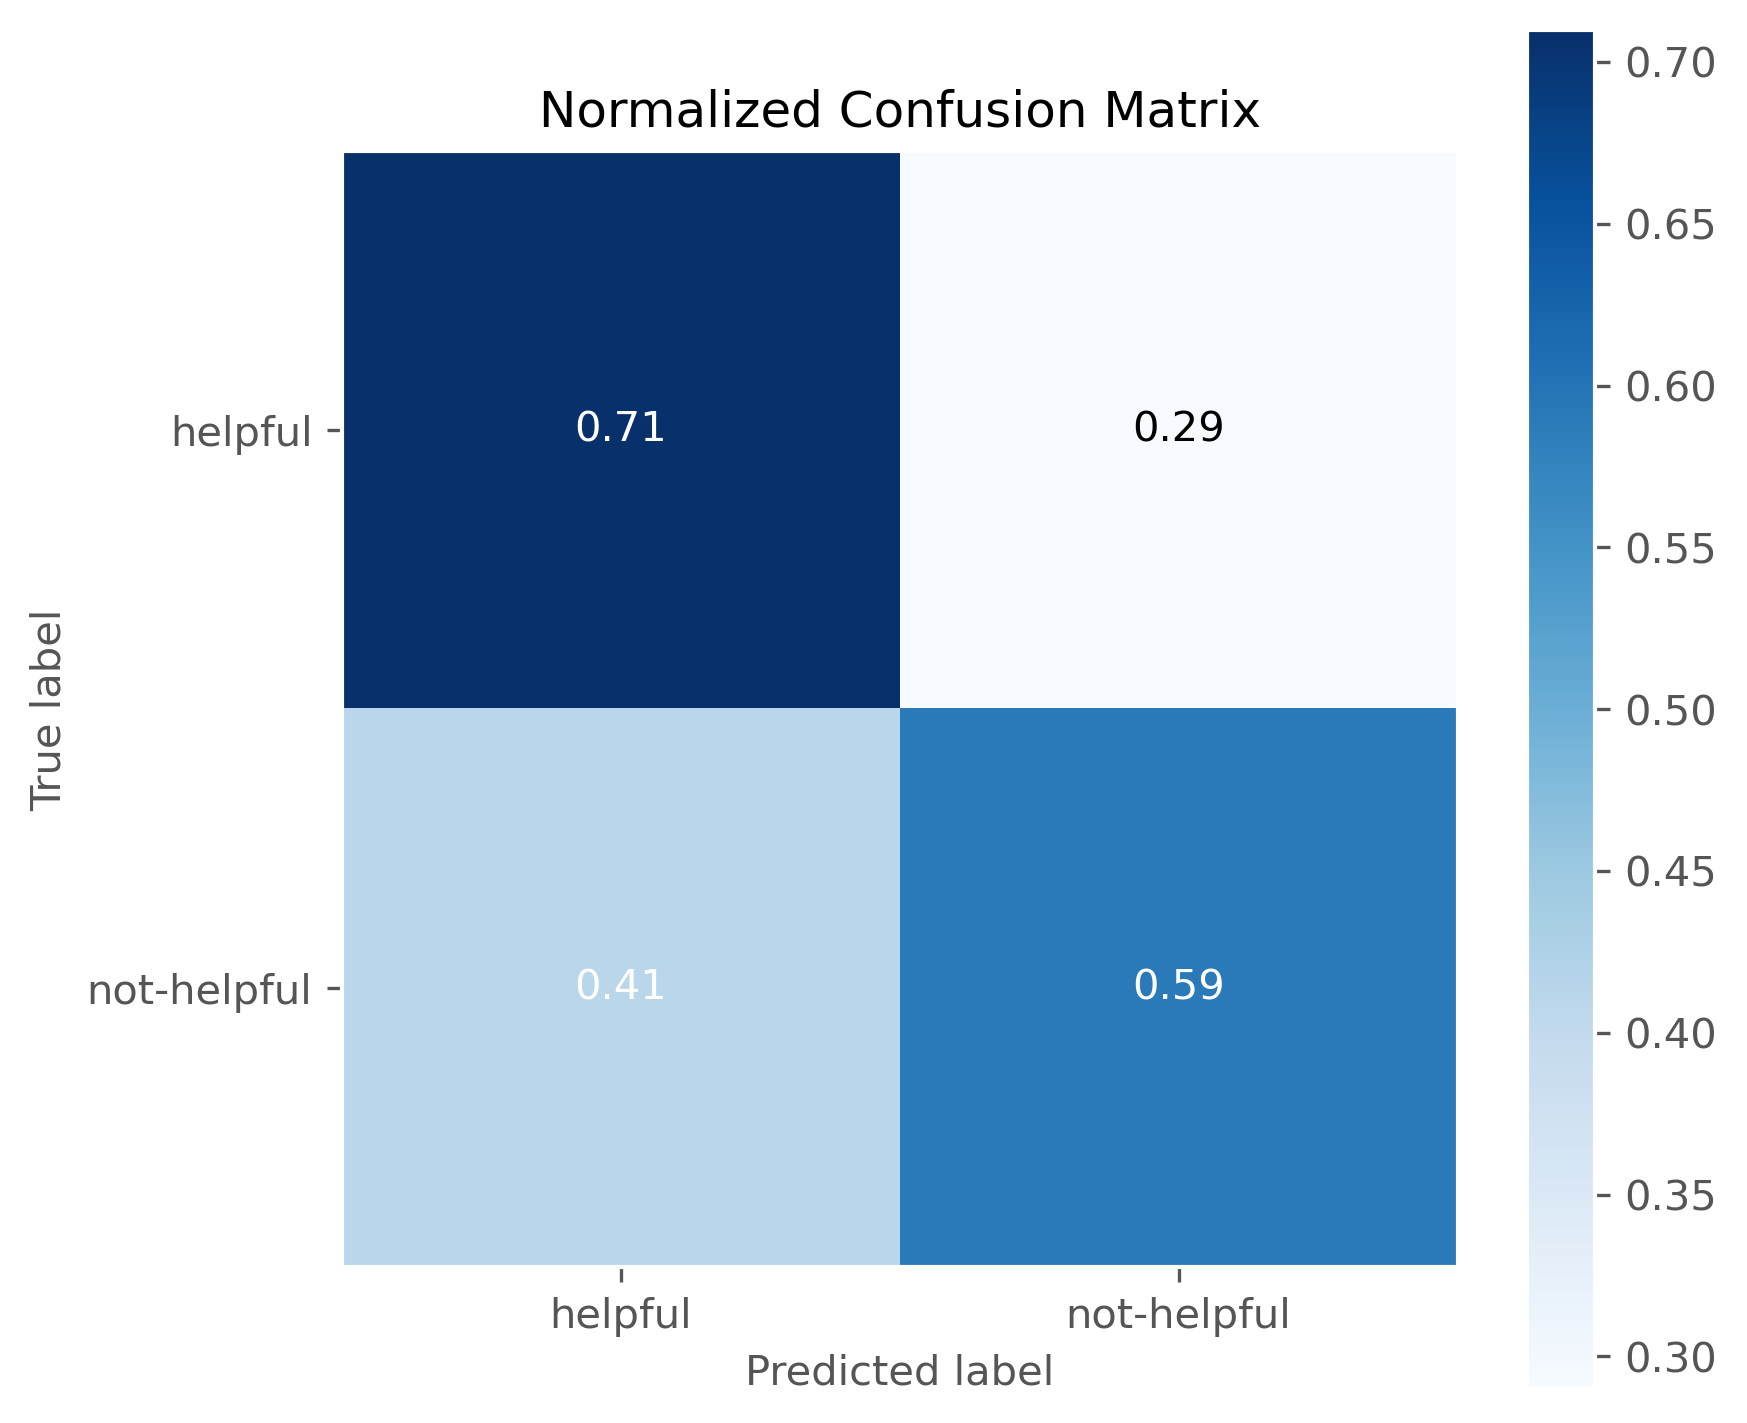

In [84]:
predictions_train_sgd, predictions_test_sgd =  pipe.predict(X_train), pipe.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_train, predictions_train_sgd, normalize = 'all',  figsize=(6,6))
plt.show()
skplt.metrics.plot_confusion_matrix(y_test, predictions_test_sgd, normalize='all',figsize=(6,6))
plt.show()

## Plotting LogReg and SGD results to compare

In [86]:
plotdf_nsgd = pd.DataFrame.from_dict(gs_sgd.cv_results_)
plotdf_nsgd.rename({'param_tfidfvectorizer__lowercase': 'Lowercase', 'param_tfidfvectorizer__ngram_range' : 'N_gram'}, axis=1, inplace=True)

In [87]:
df_models = pd.concat([plotdf_nsgd, plotdf_nlr])

In [88]:
df_models.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__average,Lowercase,N_gram,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.743489,0.058954,0.662432,0.020750,0.0001,True,True,"(1, 1)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.644231,0.653980,0.658962,0.652856,0.646697,0.651345,0.005282,11
1,10.008968,0.705568,1.947678,0.137144,0.0001,True,True,"(1, 2)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.650277,0.663233,0.661353,0.658157,0.656042,0.657812,0.004516,5
2,22.380912,0.759034,2.359247,0.105847,0.0001,True,True,"(1, 3)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.648256,0.667823,0.663970,0.657009,0.660813,0.659574,0.006687,1
3,3.312298,0.201427,0.798834,0.049199,0.0001,True,False,"(1, 1)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.644582,0.654972,0.655802,0.654280,0.650629,0.652053,0.004132,9
4,9.322660,0.219723,1.488050,0.059778,0.0001,True,False,"(1, 2)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.648559,0.660575,0.658931,0.657922,0.656363,0.656470,0.004186,8


In [96]:
df_models.head(66)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__average,Lowercase,N_gram,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.743489,0.058954,0.662432,0.020750,0.0001,True,True,"(1, 1)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.644231,0.653980,0.658962,0.652856,0.646697,0.651345,0.005282,11
1,10.008968,0.705568,1.947678,0.137144,0.0001,True,True,"(1, 2)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.650277,0.663233,0.661353,0.658157,0.656042,0.657812,0.004516,5
2,22.380912,0.759034,2.359247,0.105847,0.0001,True,True,"(1, 3)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.648256,0.667823,0.663970,0.657009,0.660813,0.659574,0.006687,1
3,3.312298,0.201427,0.798834,0.049199,0.0001,True,False,"(1, 1)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.644582,0.654972,0.655802,0.654280,0.650629,0.652053,0.004132,9
4,9.322660,0.219723,1.488050,0.059778,0.0001,True,False,"(1, 2)","{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.648559,0.660575,0.658931,0.657922,0.656363,0.656470,0.004186,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,15.591198,0.907461,2.307084,0.135579,NaN,NaN,True,"(1, 2)","{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.663321,0.672505,0.671071,0.668912,0.663187,66.779939,0.003884,3
2,35.793545,1.167302,4.102549,0.801443,NaN,NaN,True,"(1, 3)","{'tfidfvectorizer__lowercase': True, 'tfidfvec...",0.660744,0.676345,0.671905,0.665283,0.668833,66.862207,0.005361,2
3,5.990580,0.355273,1.011018,0.044389,NaN,NaN,False,"(1, 1)","{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.648685,0.658247,0.659950,0.657492,0.651219,65.511840,0.004367,6
4,17.184120,1.623083,1.890819,0.164753,NaN,NaN,False,"(1, 2)","{'tfidfvectorizer__lowercase': False, 'tfidfve...",0.660675,0.669771,0.668358,0.667230,0.667179,66.664258,0.003130,4


In [93]:
plotdf_nlr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_fit_time      6 non-null      float64
 1   std_fit_time       6 non-null      float64
 2   mean_score_time    6 non-null      float64
 3   std_score_time     6 non-null      float64
 4   Lowercase          6 non-null      object 
 5   N_gram             6 non-null      object 
 6   params             6 non-null      object 
 7   split0_test_score  6 non-null      float64
 8   split1_test_score  6 non-null      float64
 9   split2_test_score  6 non-null      float64
 10  split3_test_score  6 non-null      float64
 11  split4_test_score  6 non-null      float64
 12  mean_test_score    6 non-null      float64
 13  std_test_score     6 non-null      float64
 14  rank_test_score    6 non-null      int32  
dtypes: float64(11), int32(1), object(3)
memory usage: 824.0+ bytes


In [102]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
#plot_grid_search(pipe_grid.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

In [112]:
plot_grid_search(gs_sgd.cv_results_, Alpha, Lowercase, 'Alpha', 'Lowercase')

ValueError: cannot reshape array of size 60 into shape (1,5)

In [111]:
Lowercase = [True, False],
Alpha =  np.power(10, np.arange(-4,1,dtype=float))

In [116]:
scores = [x[1] for x in gs_sgd.cv_results_['mean_test_score']]

IndexError: invalid index to scalar variable.

In [117]:
gs_sgd.cv_results_['mean_test_score']

array([0.65134513, 0.65781223, 0.65957384, 0.65205325, 0.65646995,
       0.65859624, 0.65091946, 0.65754555, 0.65924829, 0.65194578,
       0.65653289, 0.65829153, 0.62845075, 0.62052588, 0.62611332,
       0.62749056, 0.6199076 , 0.62531813, 0.62787009, 0.62029423,
       0.62487946, 0.62704517, 0.61919831, 0.62334043, 0.6011383 ,
       0.49883077, 0.47316824, 0.60102569, 0.49474144, 0.47187116,
       0.60586708, 0.49982355, 0.47379967, 0.60599526, 0.49623165,
       0.47250127, 0.5353361 , 0.53058767, 0.49060413, 0.53475339,
       0.529152  , 0.4896868 , 0.5352381 , 0.53130615, 0.49012087,
       0.53539011, 0.52963599, 0.48983496, 0.48101635, 0.33705171,
       0.31426231, 0.47803647, 0.33676303, 0.31436894, 0.48051666,
       0.33744578, 0.31433021, 0.47647976, 0.33712284, 0.31440765])

# Applying the model to the uncategorised reviews

Best score acheived comparing these 2 models is x. Even though the false positives are x, it still helps to filter out the low quality reviews which would still improve the user experience.

For further works on this project I would like to trial training a spellchecker as there is a lot of misspellings and even more slang language in the corpus.

I would also like to try other models that would be better at capturing semantic meaning such a word embeddings (word2vec model) or deep learning models.

Precision for our model is 72%, it predicts high salary 72% of the time Recall is 72%, the sensitivity/true positive rate, our model is able to accurately identify the relevant data 72% of the time We have tested a variety of models and parameters using gridsearch for parameter tuning to arrive at these scores. To improve the model further we could look at gathering data on new additional features to what we have obtained above